In [1]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
def my_skin_detect(src):
    '''
    Start with red > 95 and go from there
    
    
    Function that detects whether a pixel belongs to the skin based on RGB values
    Args: 
        src The source color image
    Returns: 
        dst The destination grayscale image where skin pixels are colored white and the rest are colored black
    Surveys of skin color modeling and detection techniques:
    Vezhnevets, Vladimir, Vassili Sazonov, and Alla Andreeva. "A survey on pixel-based skin color detection techniques." Proc. Graphicon. Vol. 3. 2003.
    Kakumanu, Praveen, Sokratis Makrogiannis, and Nikolaos Bourbakis. "A survey of skin-color modeling and detection methods." Pattern recognition 40.3 (2007): 1106-1122.
    '''
    dst = np.zeros(np.shape(src)[:-1], dtype=np.uint8)
    
    mask = np.logical_and.reduce((src[:,:,0] > 20, src[:,:,1] > 40, src[:,:,2] > 95, 
                                    src.max(axis=-1) - src.min(axis=-1) > 15, 
                                    abs(src[:,:,2] - src[:,:,1]) > 15, 
                                    src[:,:,2] > src[:,:,1], src[:,:,2] > src[:,:,0]))
    
    dst[mask] = 255

    # Too slow
    # for i in range(np.shape(src)[0]):
    #     for j in range(np.shape(src)[1]):
    #         b, g, r = src[i][j]
    #         if r > 95 and g > 40 and b > 20 \
    #             and (max(r, g, b) - min(r, g, b) > 15) \
    #             and abs(r - g) > 15 and r > g and r > b:
    #             dst[i][j] = 255
    return dst

def my_frame_differencing(prev, curr):
    '''
    Function that does frame differencing between the current frame and the previous frame
    Args:
        src The current color image
        prev The previous color image
    Returns:
        dst The destination grayscale image where pixels are colored white if the corresponding pixel intensities in the current
    and previous image are not the same
    '''
    dst = cv2.absdiff(prev, curr)
    gs = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    dst = (gs > 50).astype(np.uint8) * 255
    return dst

def my_motion_energy(mh):
    '''
    Function that accumulates the frame differences for a certain number of pairs of frames
    Args:
        mh Vector of frame difference images
    Returns:
        dst The destination grayscale image to store the accumulation of the frame difference images
    '''
    dst = np.zeros(np.shape(mh[0]), dtype=np.uint8)
    mask = np.logical_or.reduce([m == 255 for m in mh])
    dst[mask] = 255
    return dst

In [3]:
def create_template(template_list):
    grayscaled_template_list = []
    for template in template_list:
        template_grayscaled = cv2.imread(template, cv2.IMREAD_GRAYSCALE)
        grayscaled_template_list.append(template_grayscaled)
        
    return grayscaled_template_list

In [4]:
def show_template(template_list):
    for template in template_list:
        plt.figure(figsize=(10, 10))

        plt.subplot(2, 1, 2)
        plt.imshow(template, cmap = 'gray')
        plt.title('Template')
        plt.axis('off')

        plt.show()

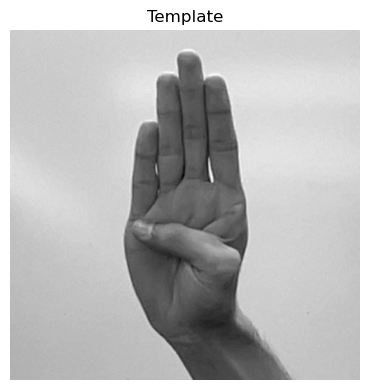

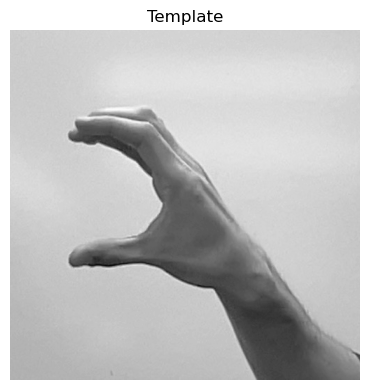

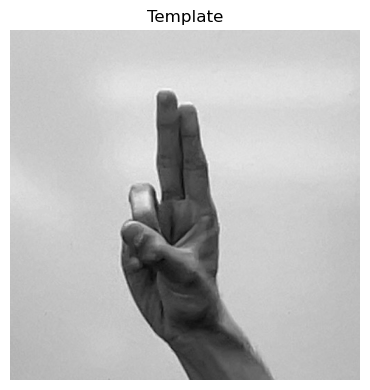

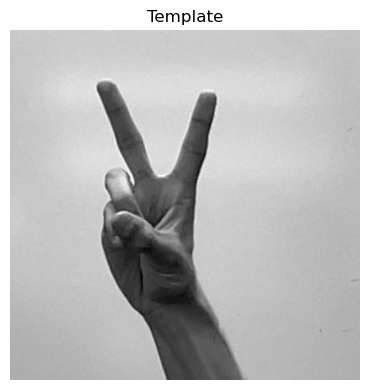

In [5]:
template_list = ['B_img.jpg', 'C_img.jpg', 'U_img.jpg', 'V_img.jpg']
grayscaled_template_list = create_template(template_list)
show_template(grayscaled_template_list)

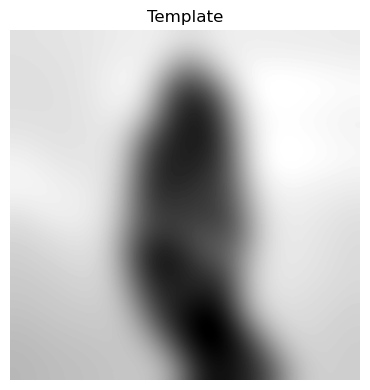

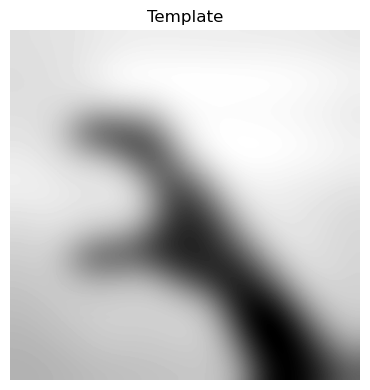

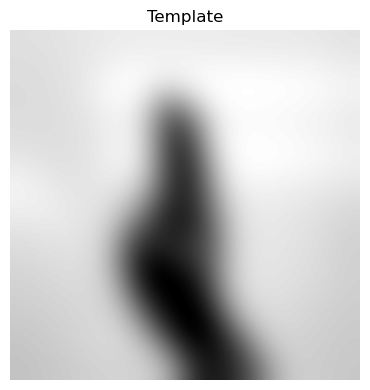

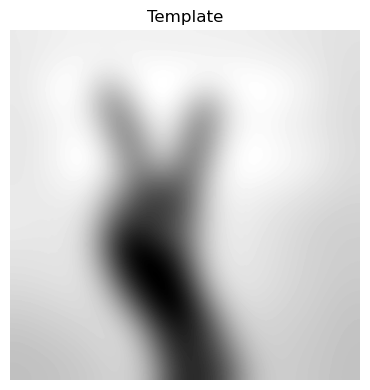

In [34]:
blurred_templates_list = [cv2.GaussianBlur(
    img, (175, 175), 0) for img in grayscaled_template_list]
show_template(blurred_templates_list)


In [28]:
def my_template_matching(frame, template):
    w, h = template.shape[::-1]
#     methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 
#             'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
    methods = ['cv2.TM_CCORR_NORMED']

    for meth in methods:
        img = frame.copy()
        method = eval(meth)
        # Apply template Matching
        # https://docs.opencv.org/3.4/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be
        similarity_map = np.zeros((img.shape[0] - template.shape[0] + 1, img.shape[1] - template.shape[1] + 1))
        res = cv2.matchTemplate(img, template, method, similarity_map)
        # Find min/max location: https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res)
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
#         if method == methods[-2] or method == methods[-1]:
#             top_left = minLoc
#         else:
        top_left = maxLoc


        bottom_right = (top_left[0] + w,  top_left[1] + h)
        
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        cv2.rectangle(img, top_left, bottom_right, (0, 0, 255), 2)
        plt.figure(figsize=(20, 6))
        plt.subplot(121)
        plt.imshow(res, cmap='gray')
        plt.title('Matching Result')
        plt.xticks([]), plt.yticks([])
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Detected Point')
        plt.xticks([]), plt.yticks([])
        plt.suptitle(meth)
        plt.show()
        
    return maxVal
        

In [29]:
def best_template(frame, template_list):
    max_vals = []
    for template in template_list:
        max_val = my_template_matching(frame, template)
        max_vals.append(max_val)
    
    print(max_vals)
    index_max = max_vals.index(max(max_vals))
    print(index_max)
    if index_max == 0:
        print('B')
    elif index_max == 1:
        print('C')
    elif index_max == 2:
        print('U')
    elif index_max == 3:
        print('V')
    
    return max_vals
        
        

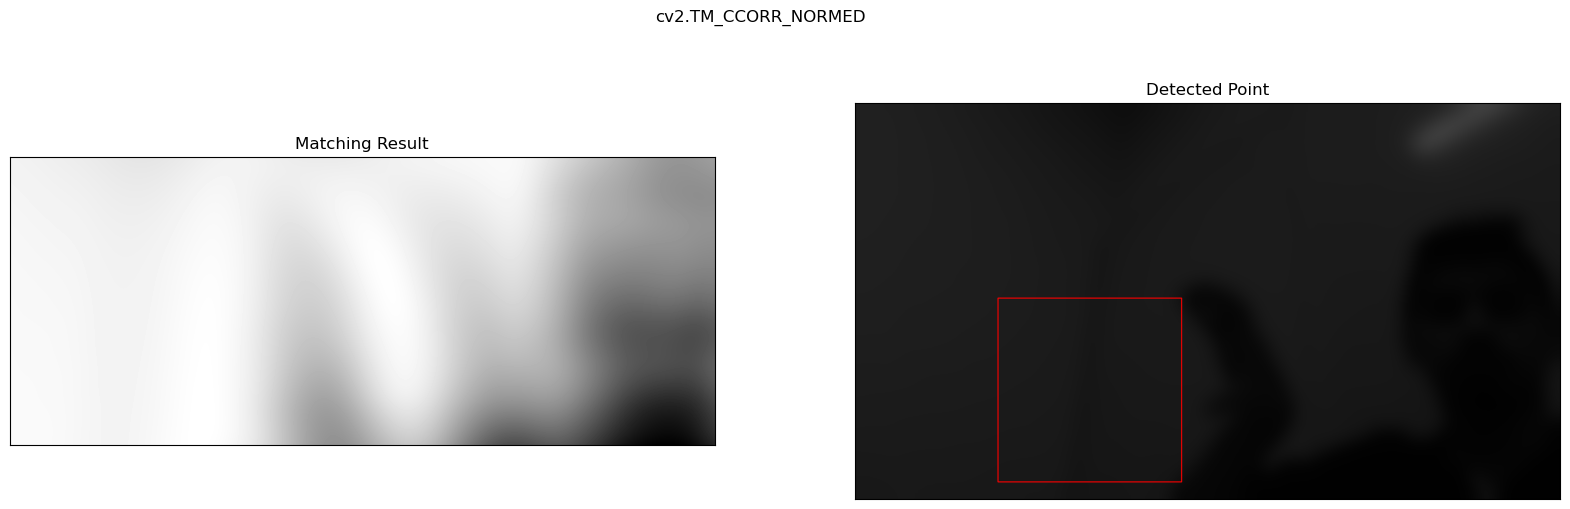

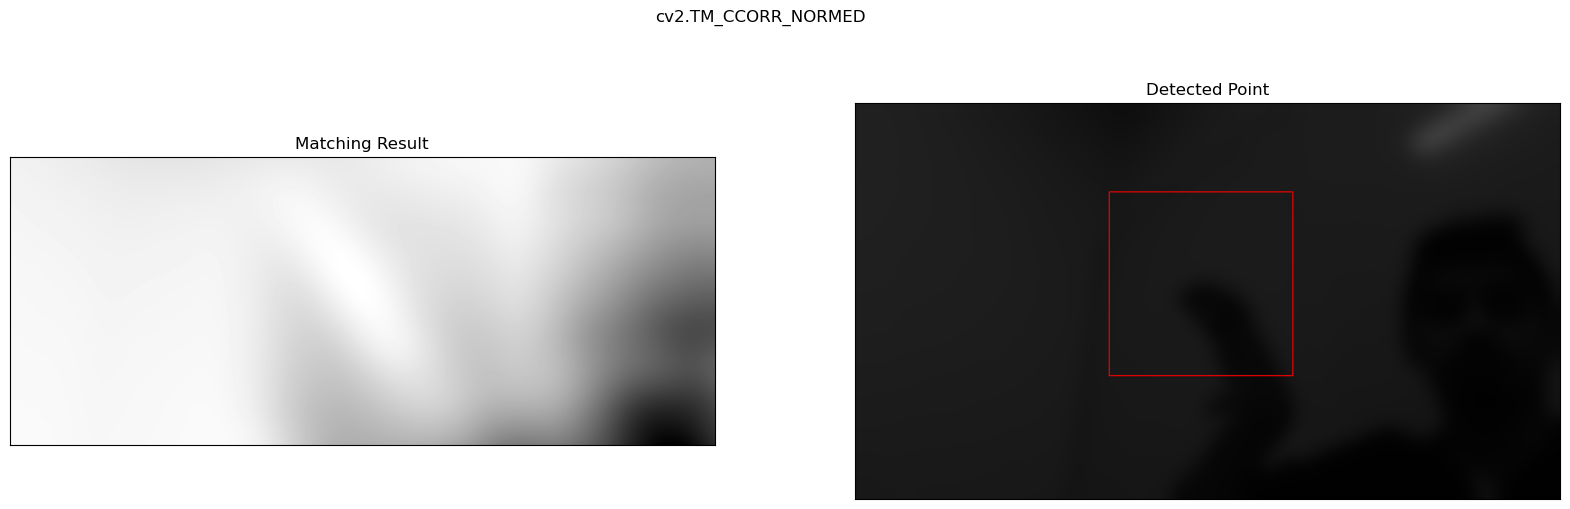

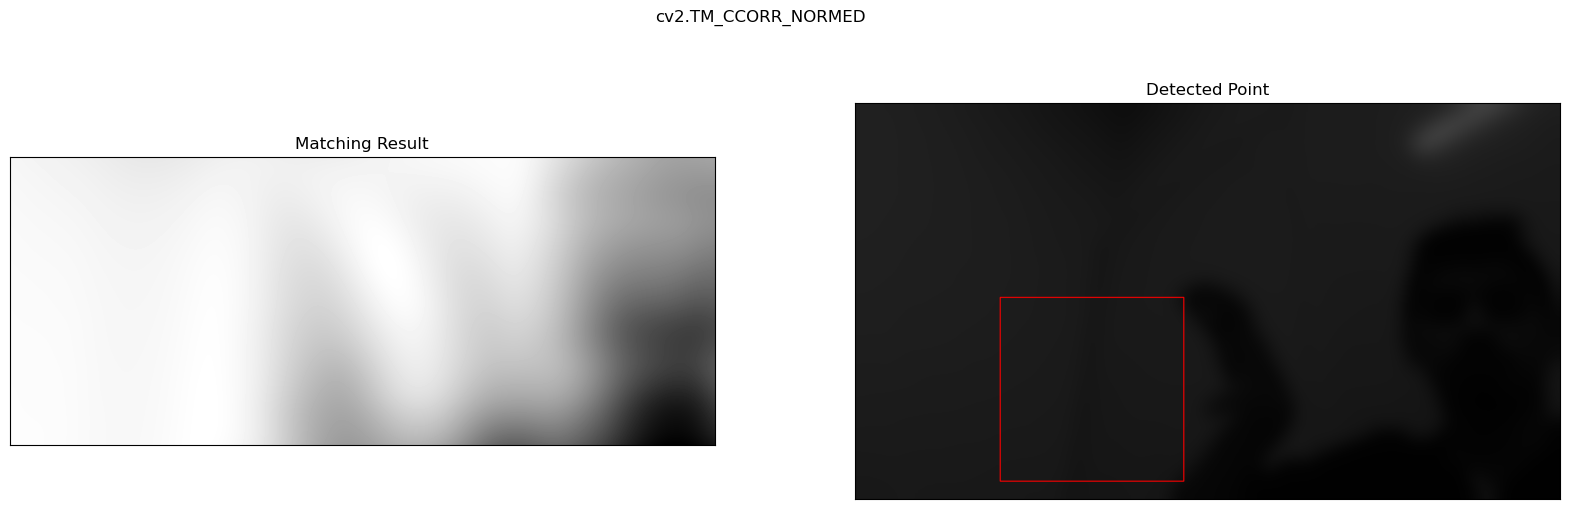

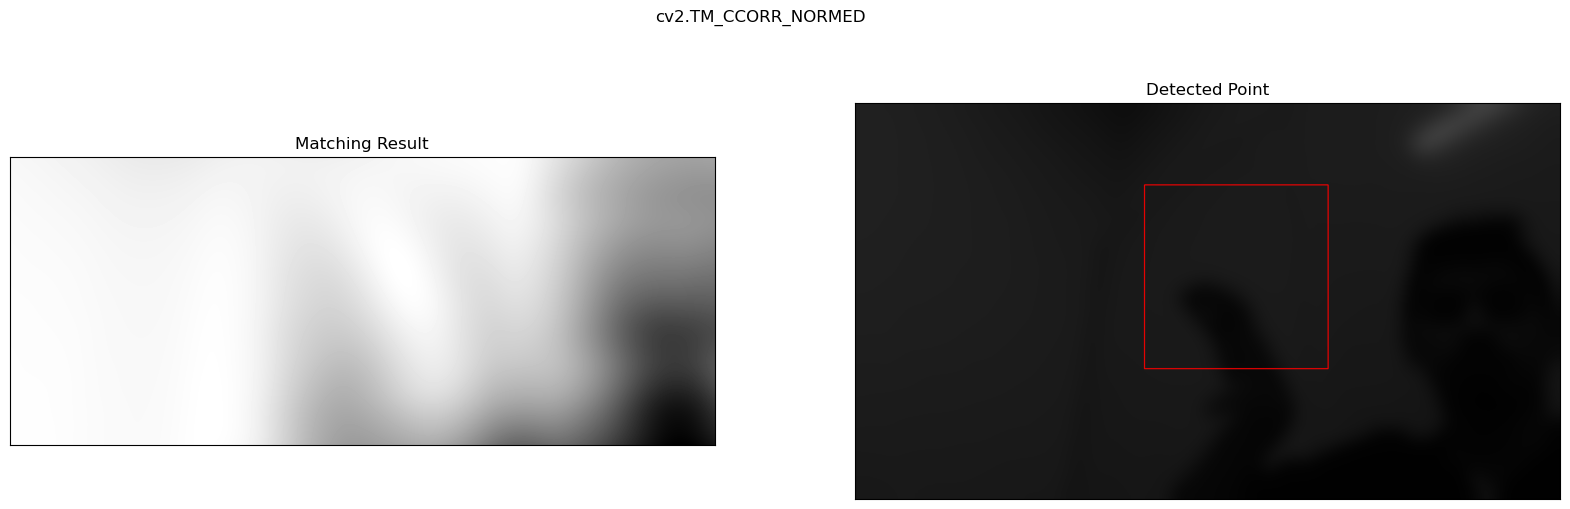

[0.9850002527236938, 0.9916383624076843, 0.9909977912902832, 0.9911494255065918]
1
C


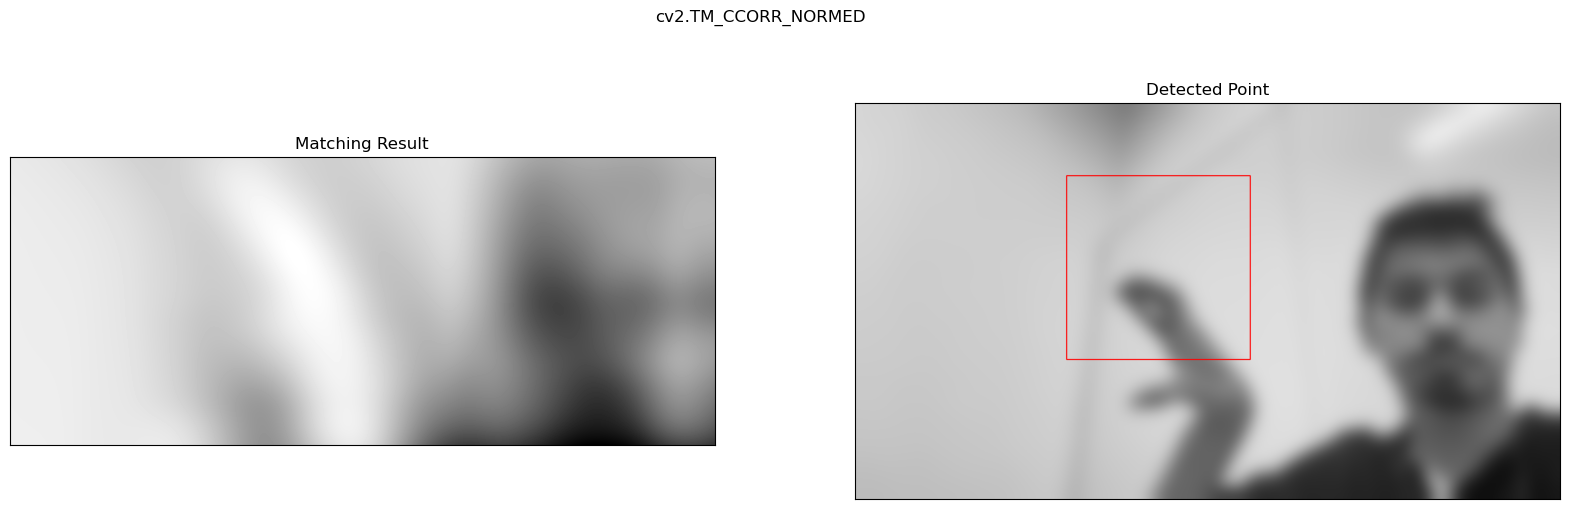

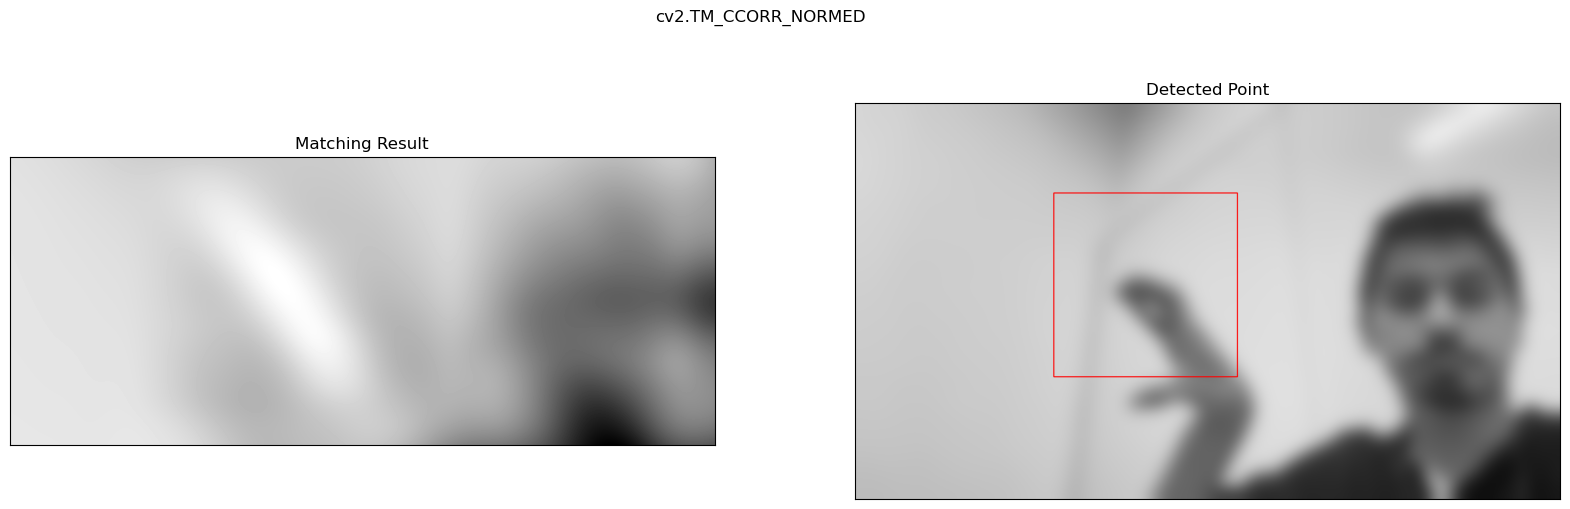

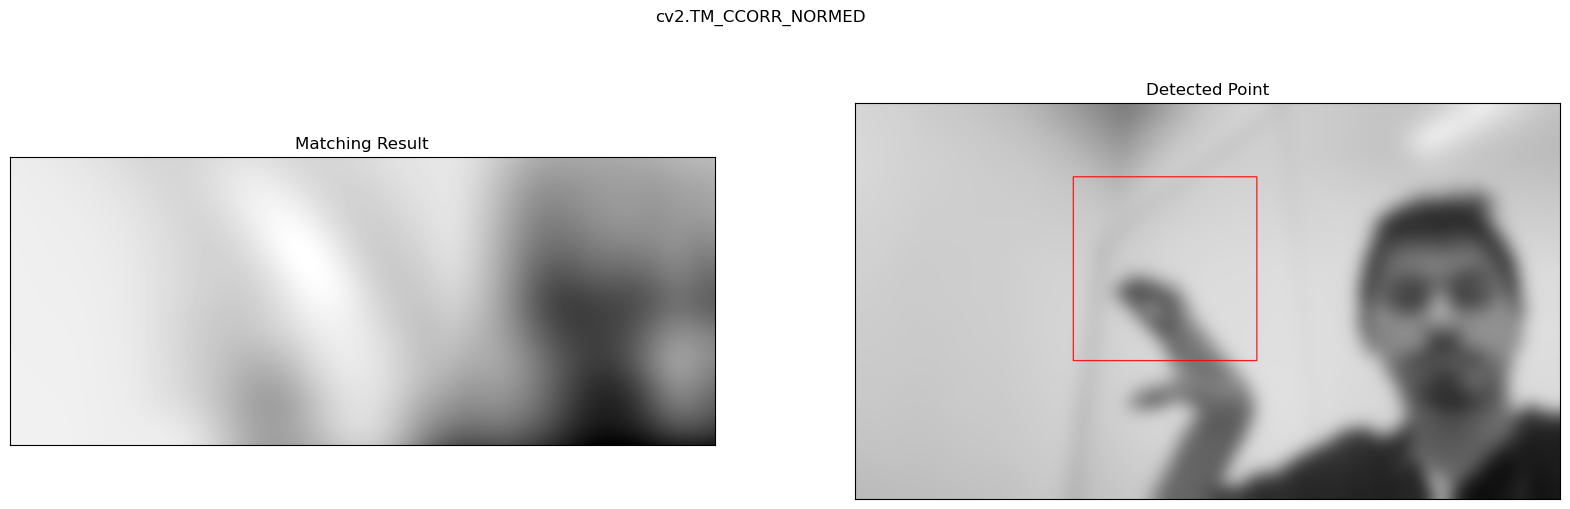

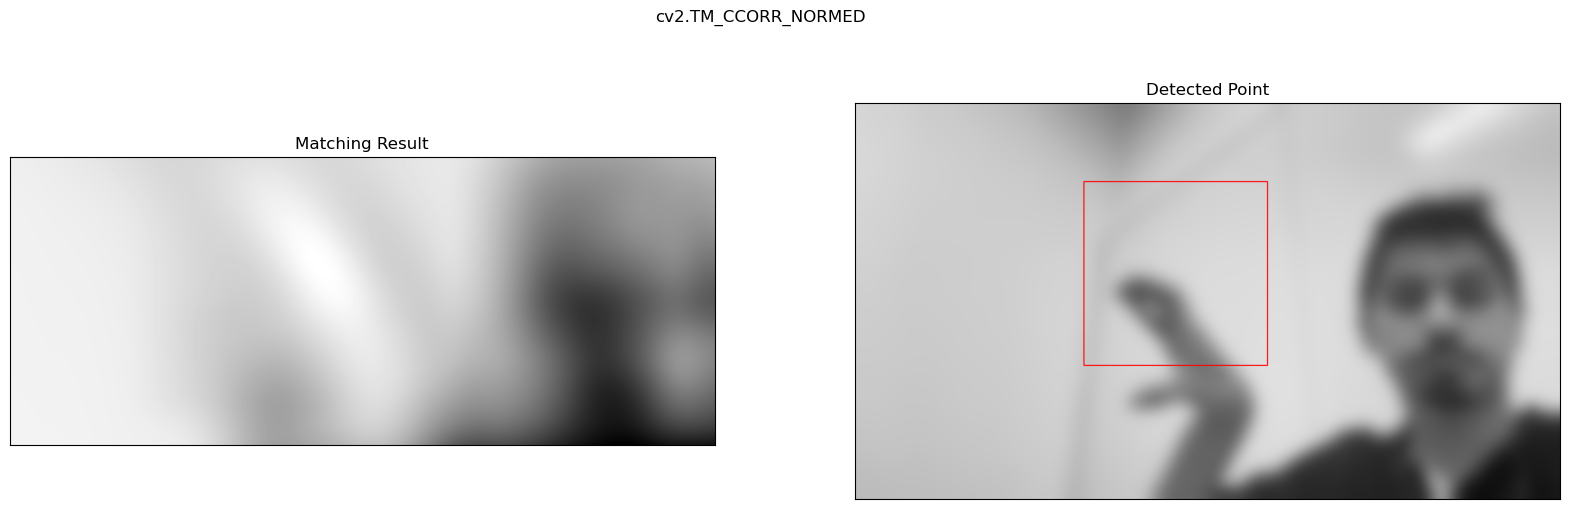

[0.9870843887329102, 0.9955444931983948, 0.9938381910324097, 0.9945133924484253]
1
C


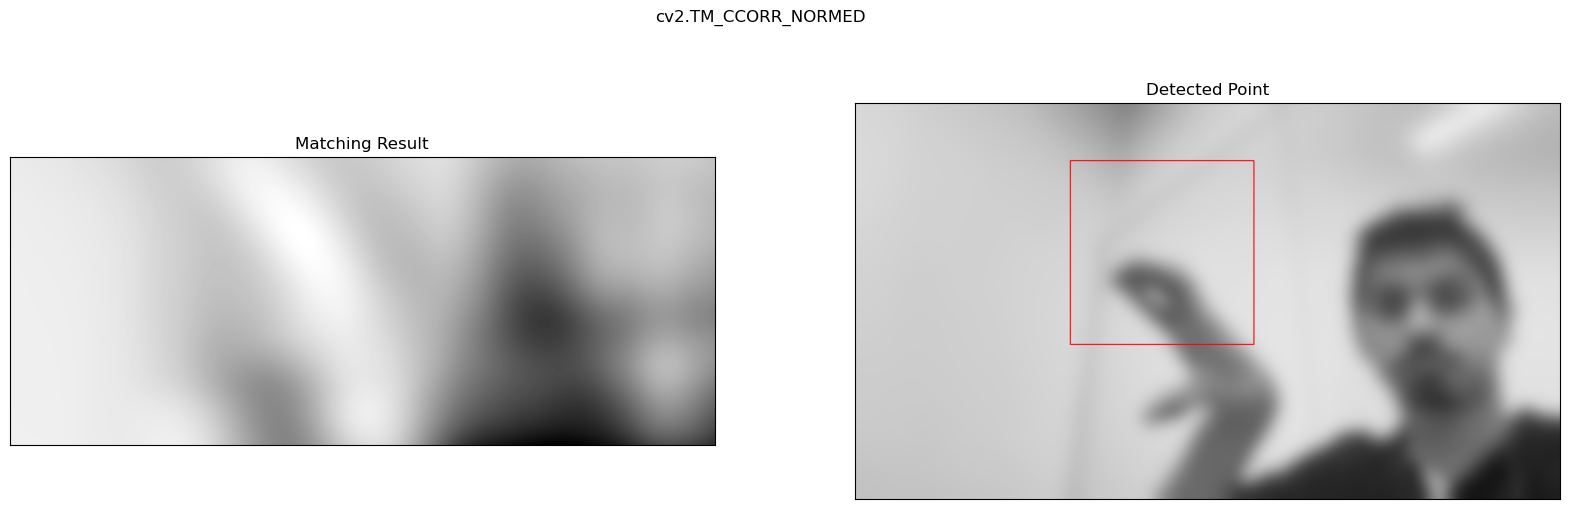

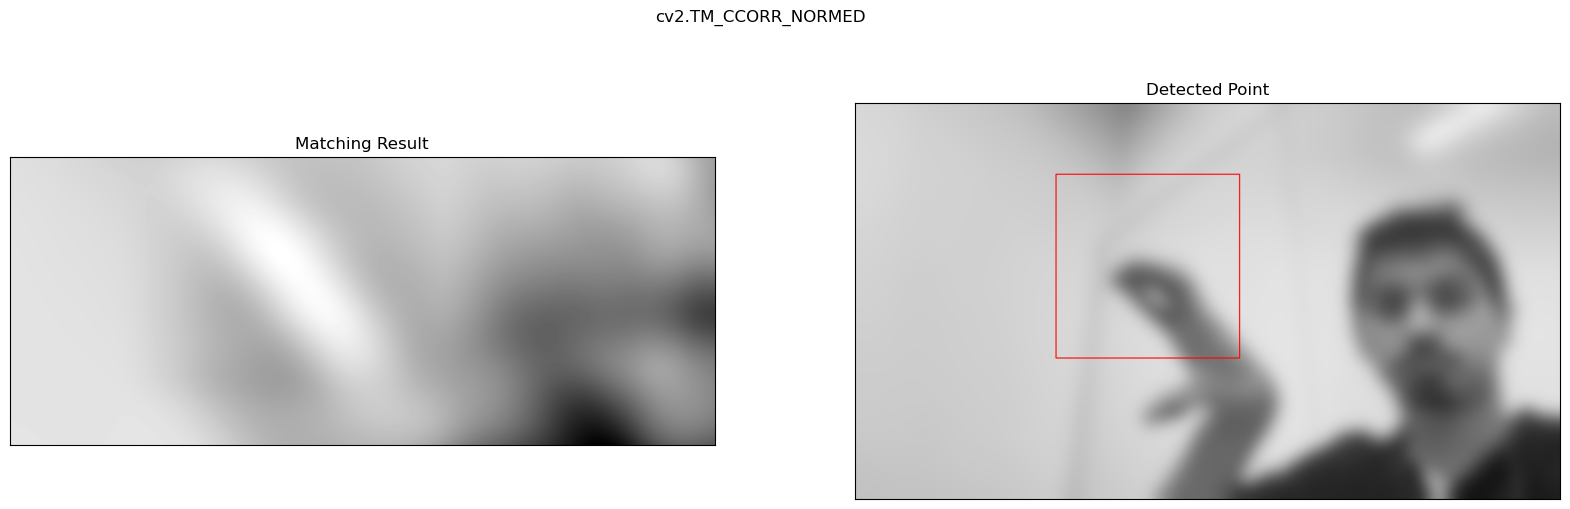

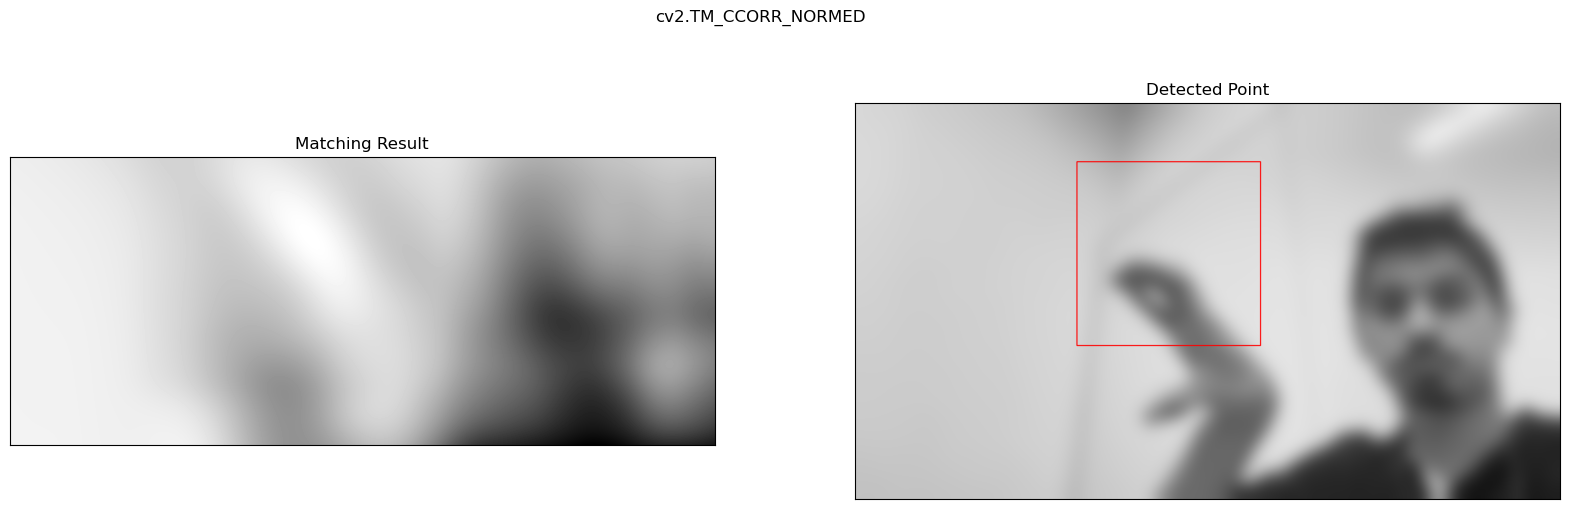

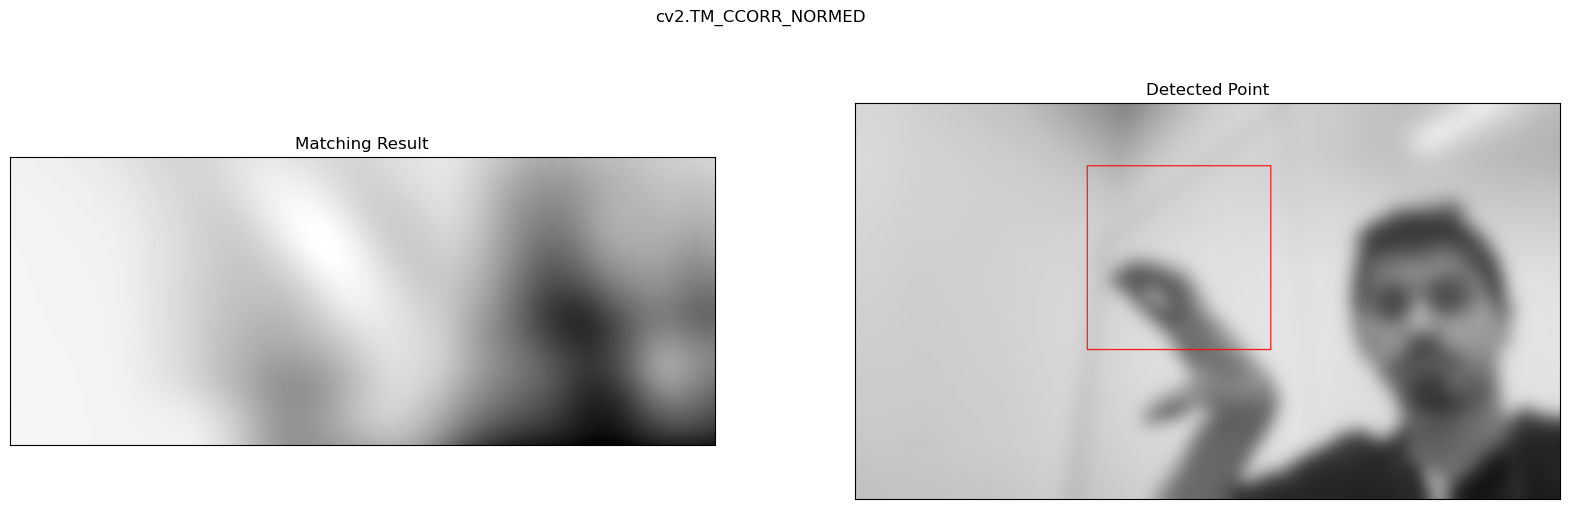

[0.985942542552948, 0.9952190518379211, 0.9924936890602112, 0.9926916360855103]
1
C


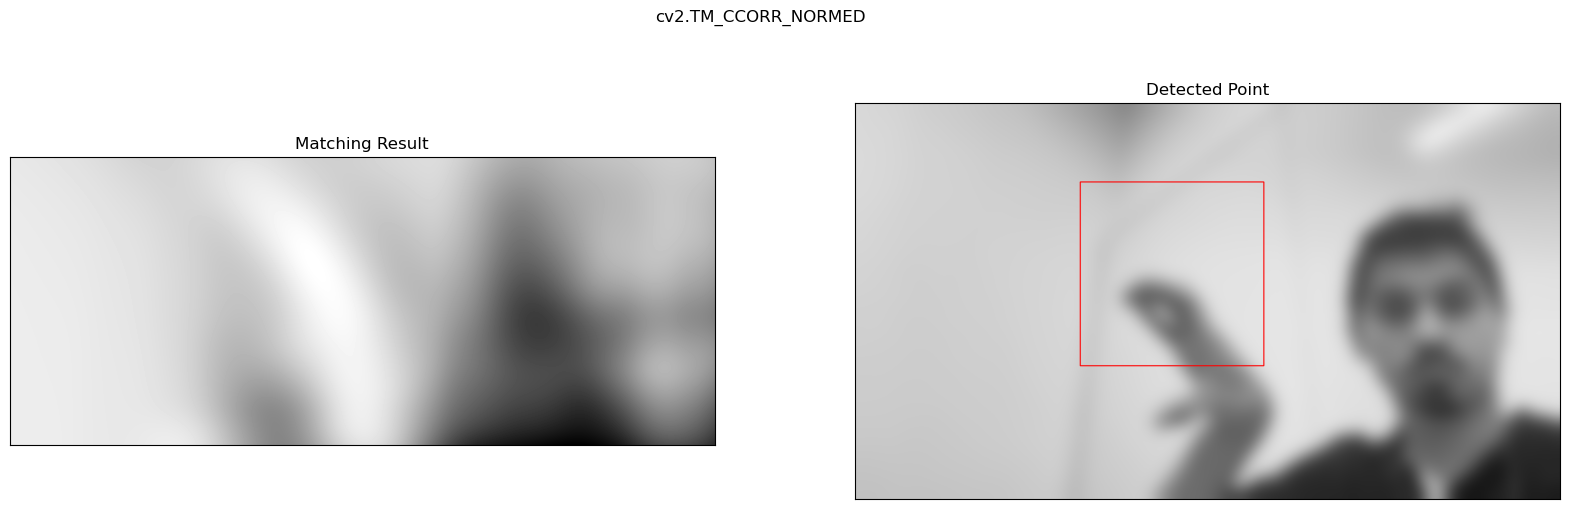

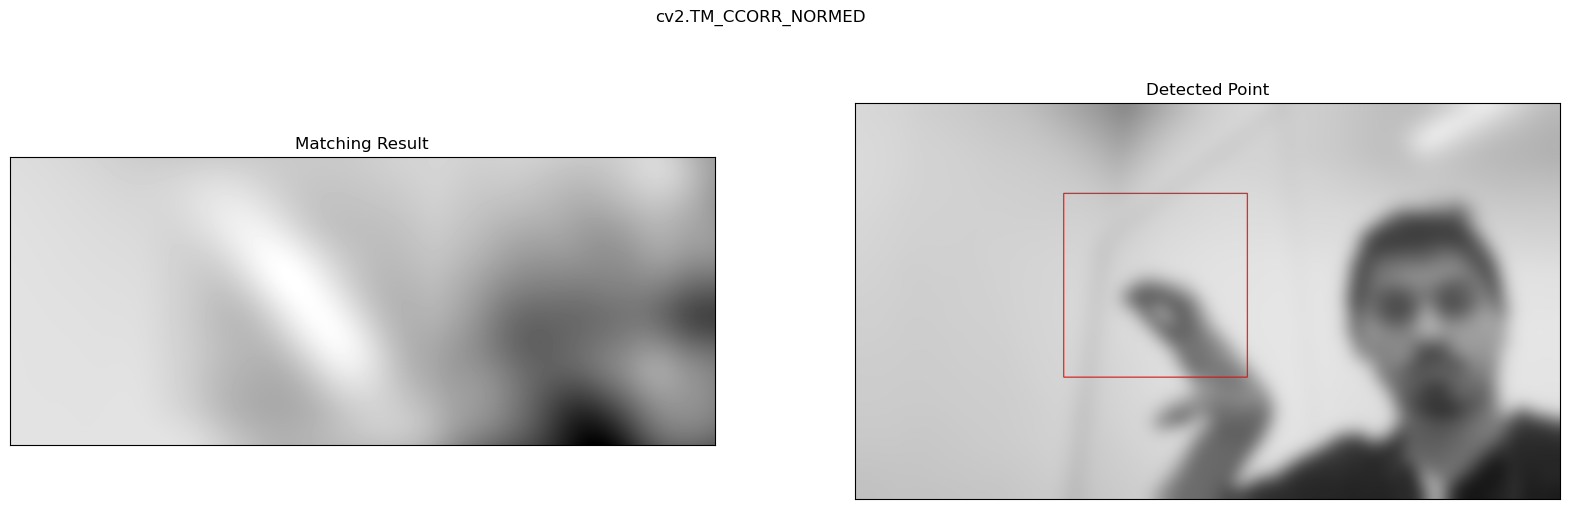

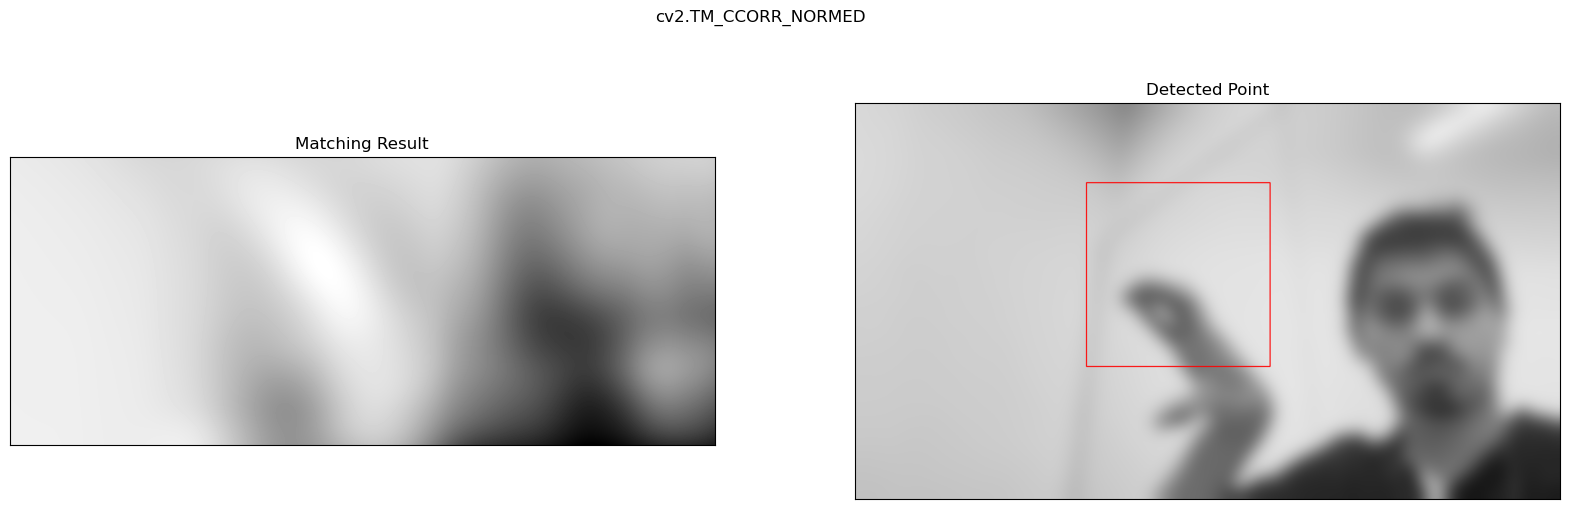

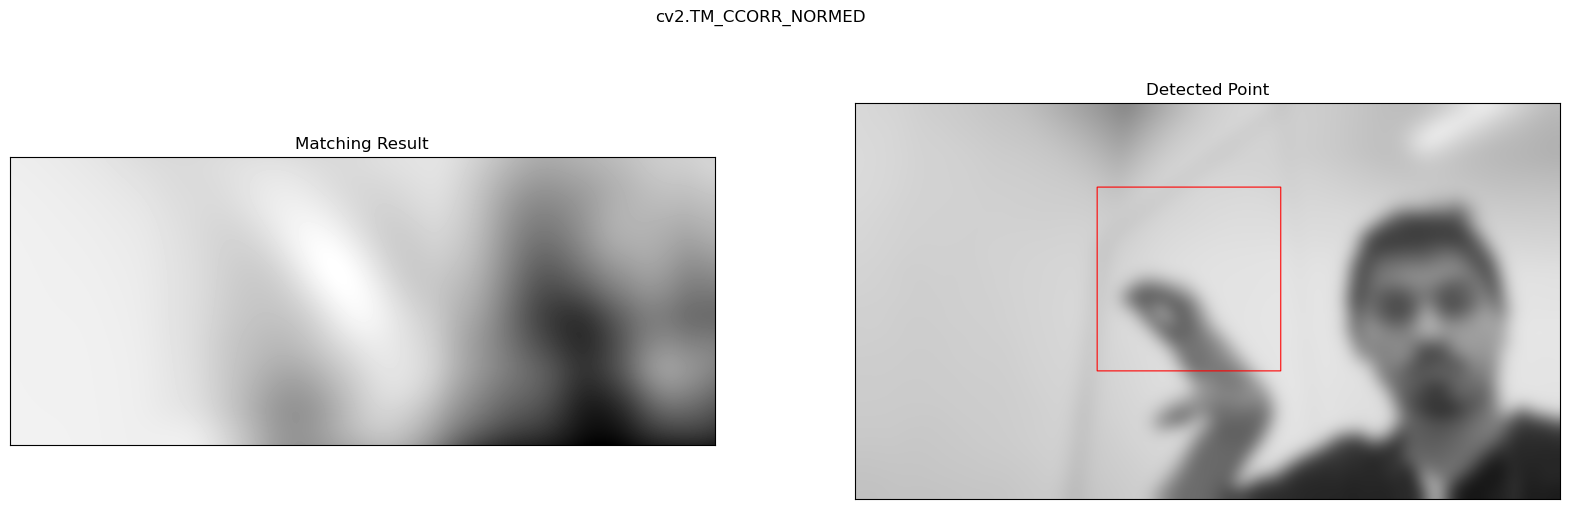

[0.9865993857383728, 0.9956747889518738, 0.993587076663971, 0.9940899610519409]
1
C


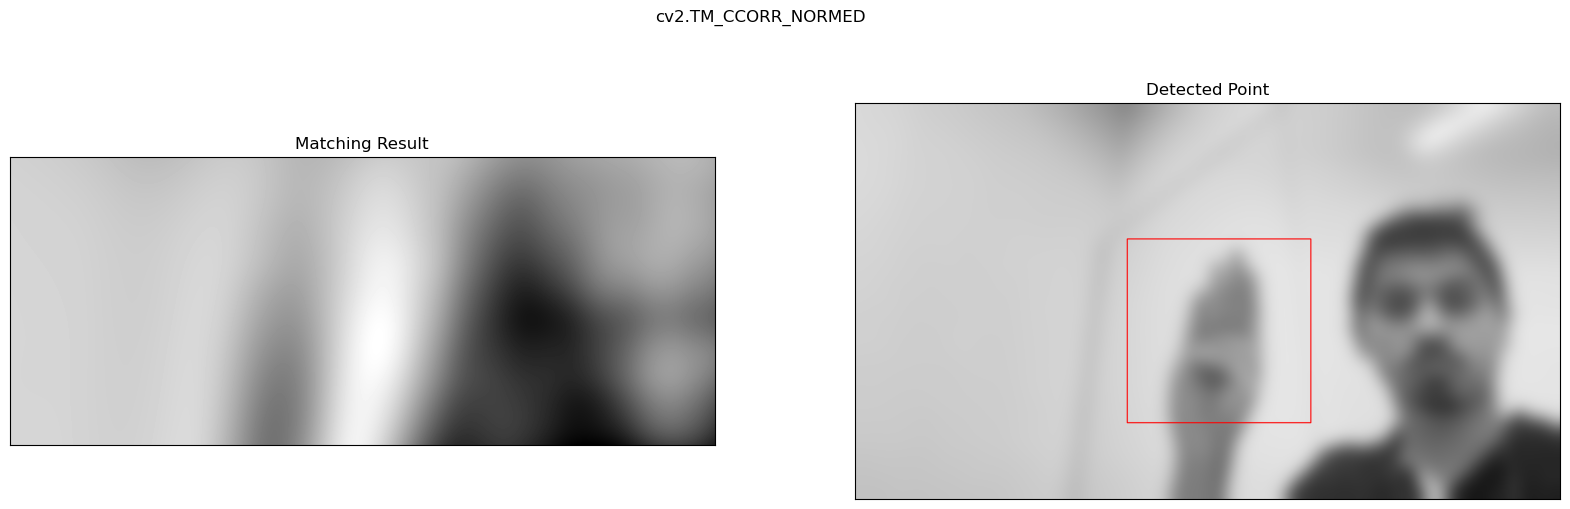

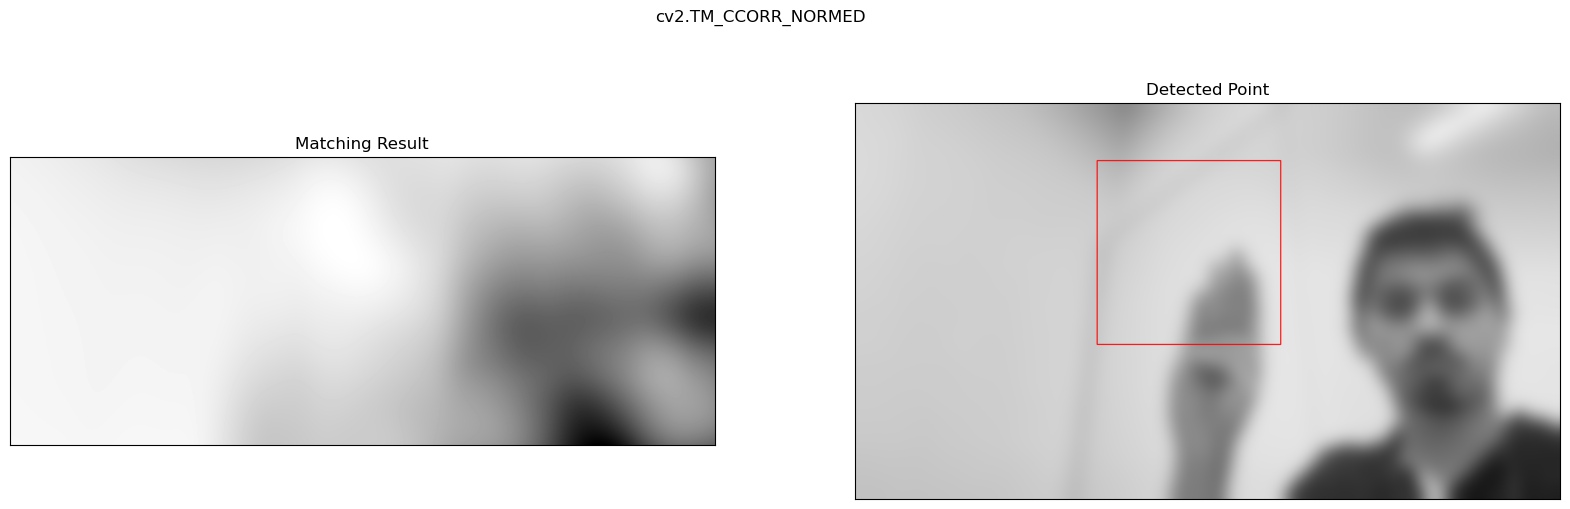

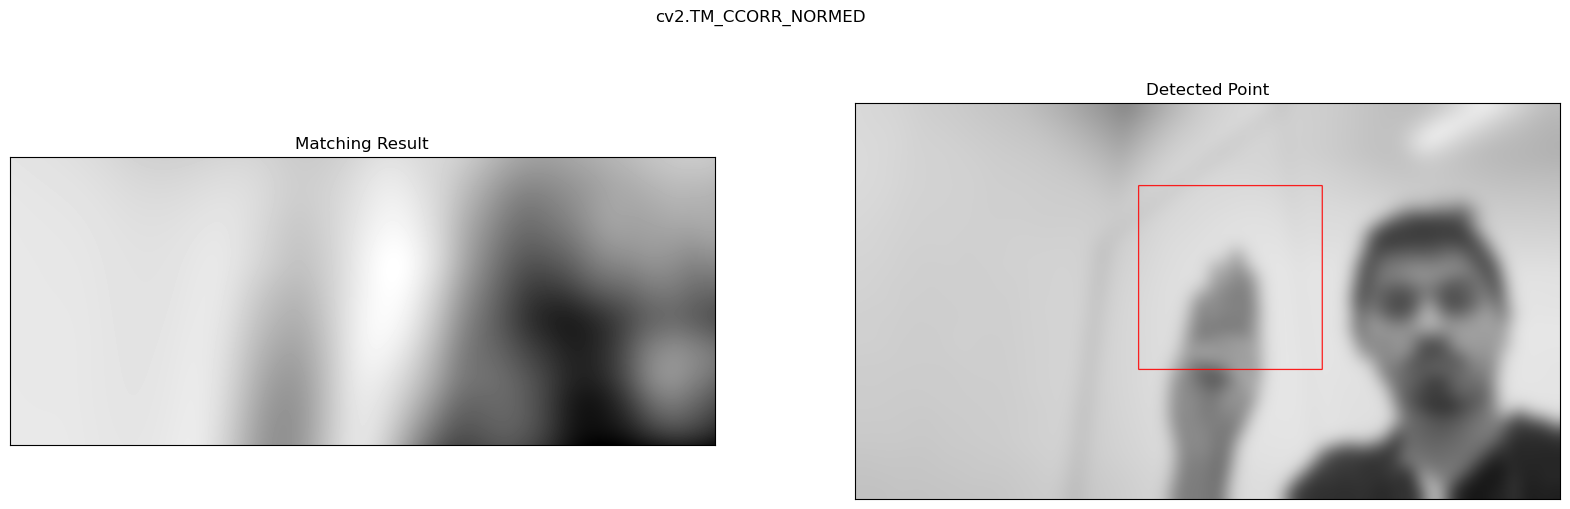

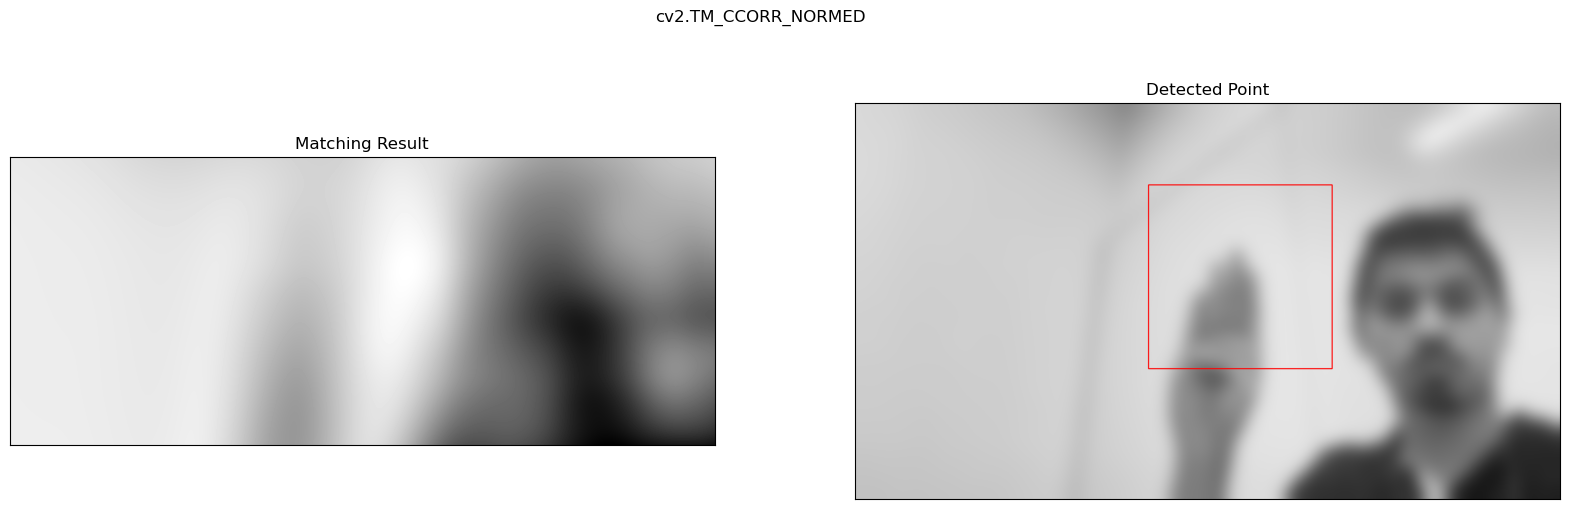

[0.9936681985855103, 0.9859917163848877, 0.9948024749755859, 0.9946313500404358]
2
U


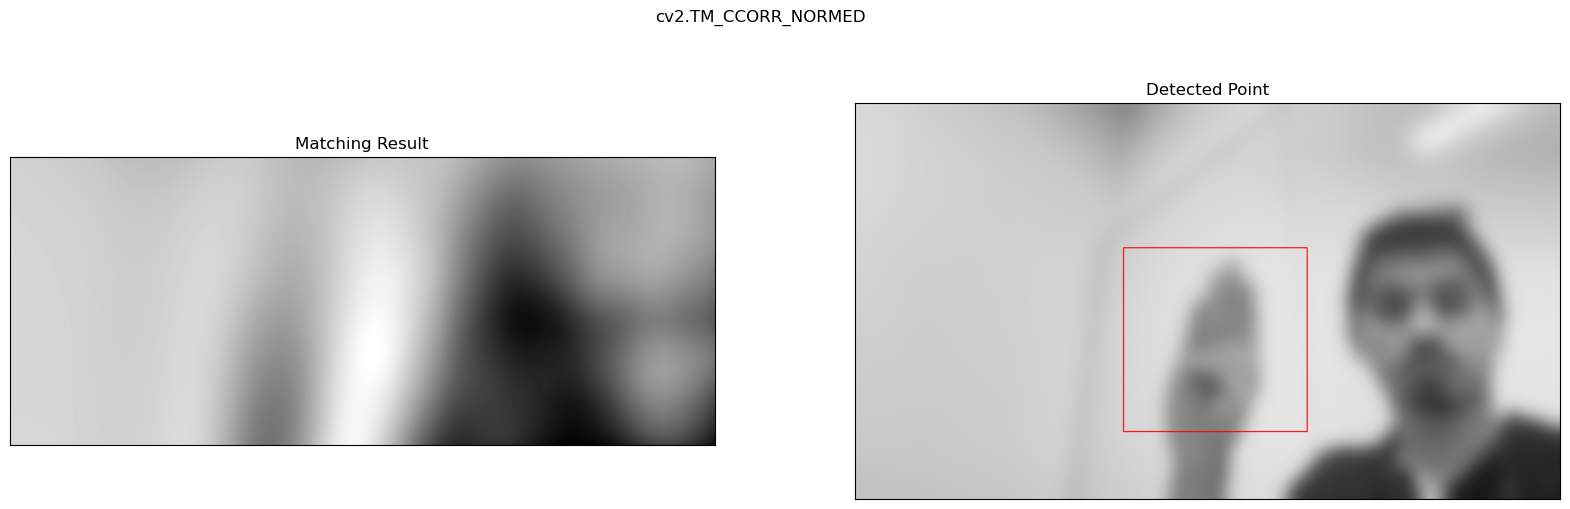

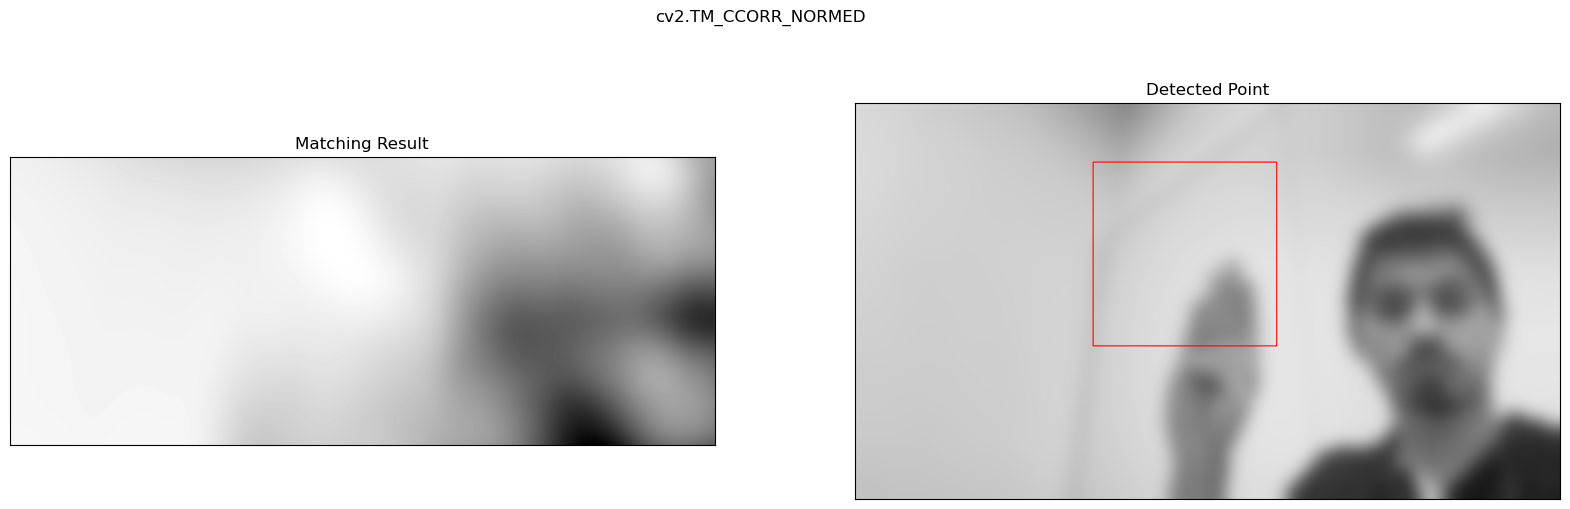

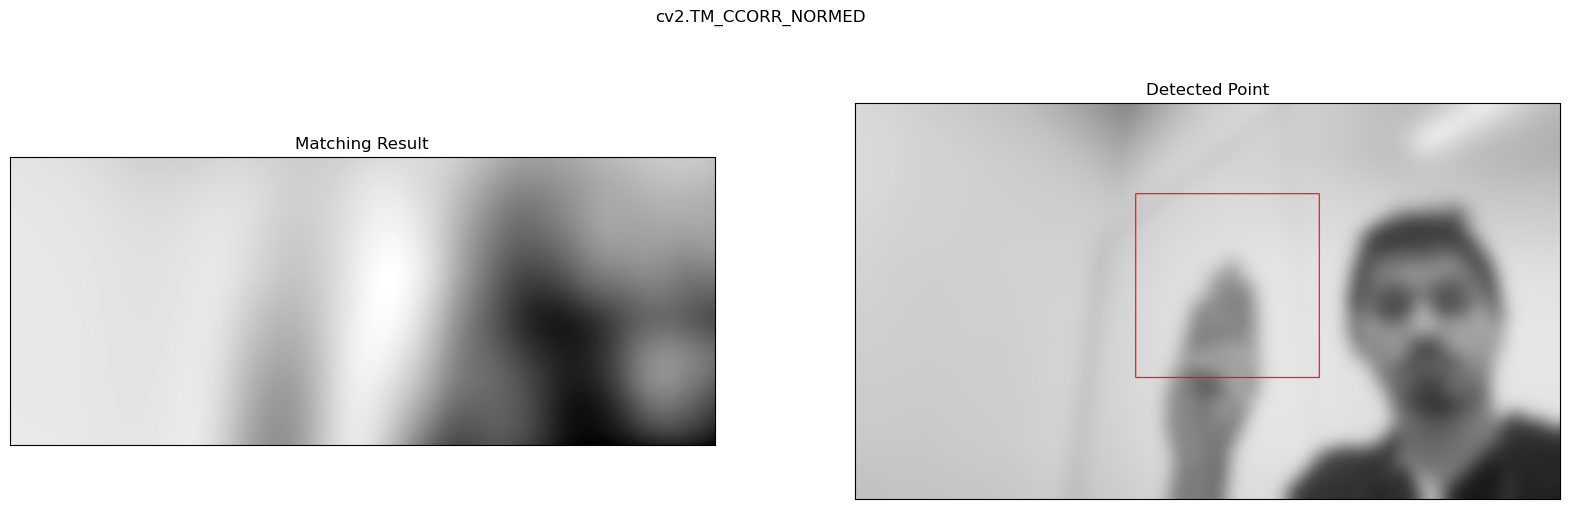

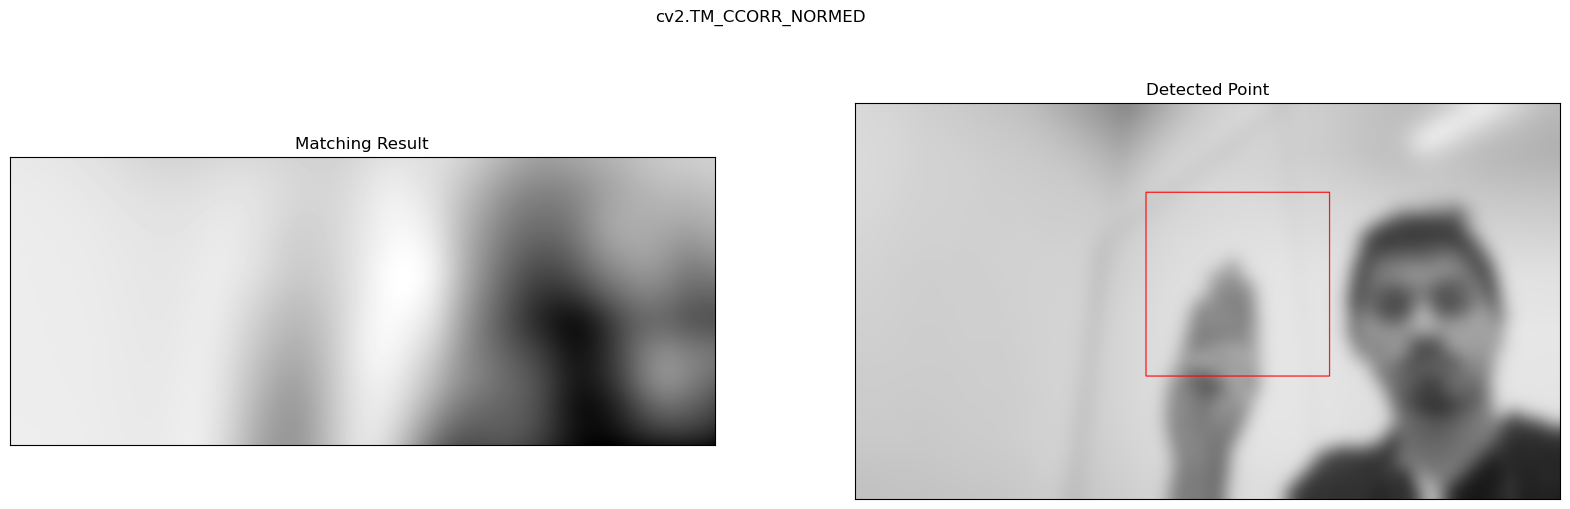

[0.9930317997932434, 0.986095666885376, 0.9946894645690918, 0.9945632219314575]
2
U


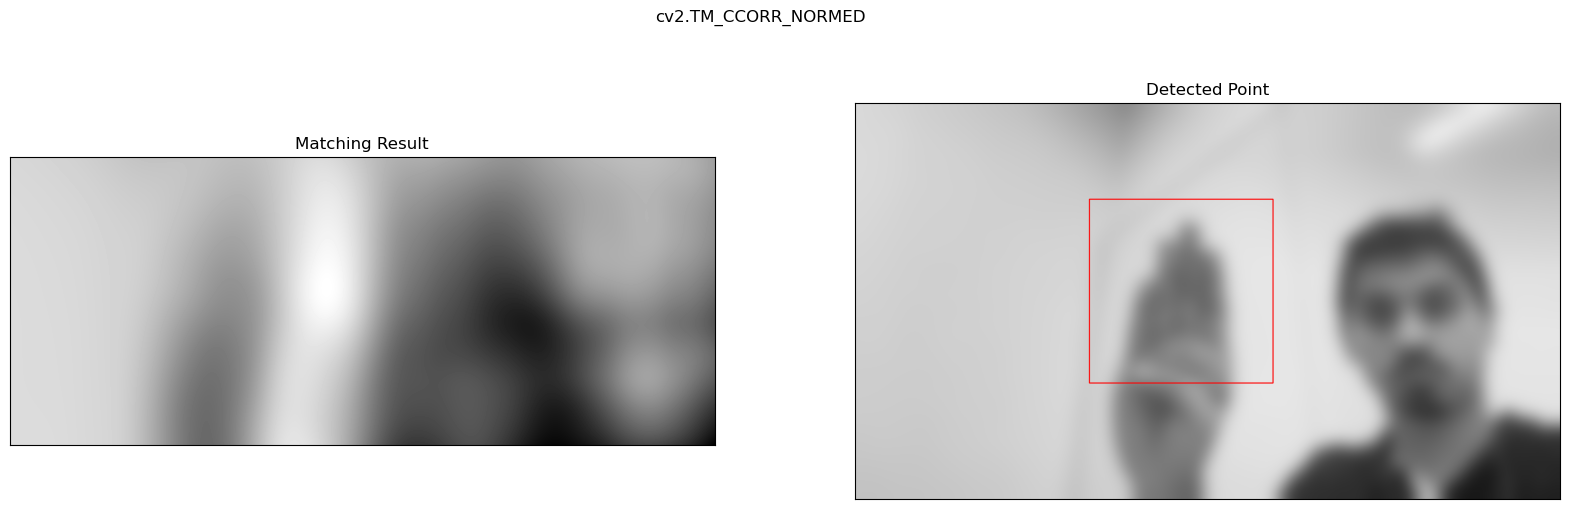

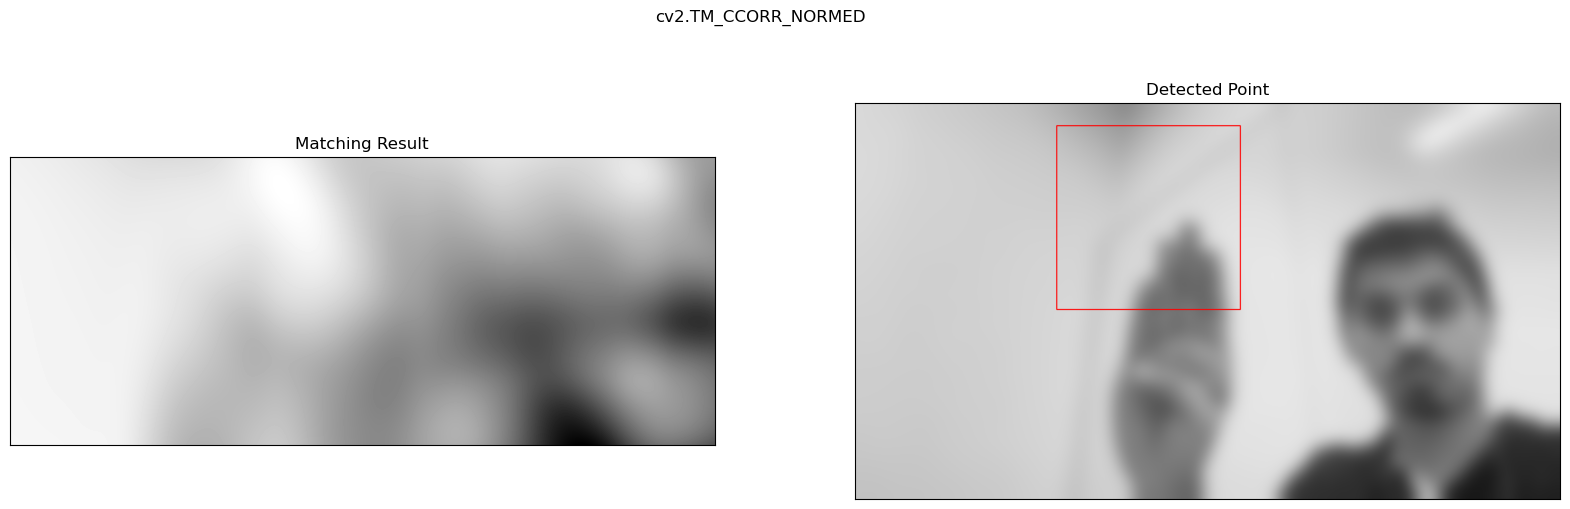

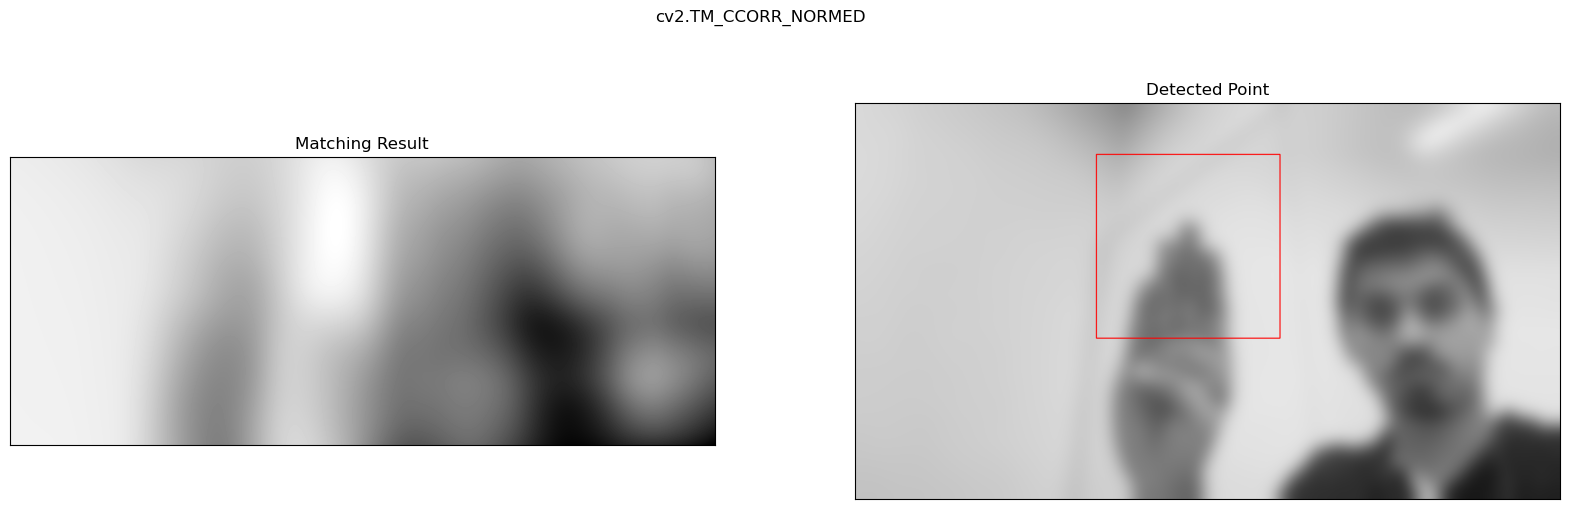

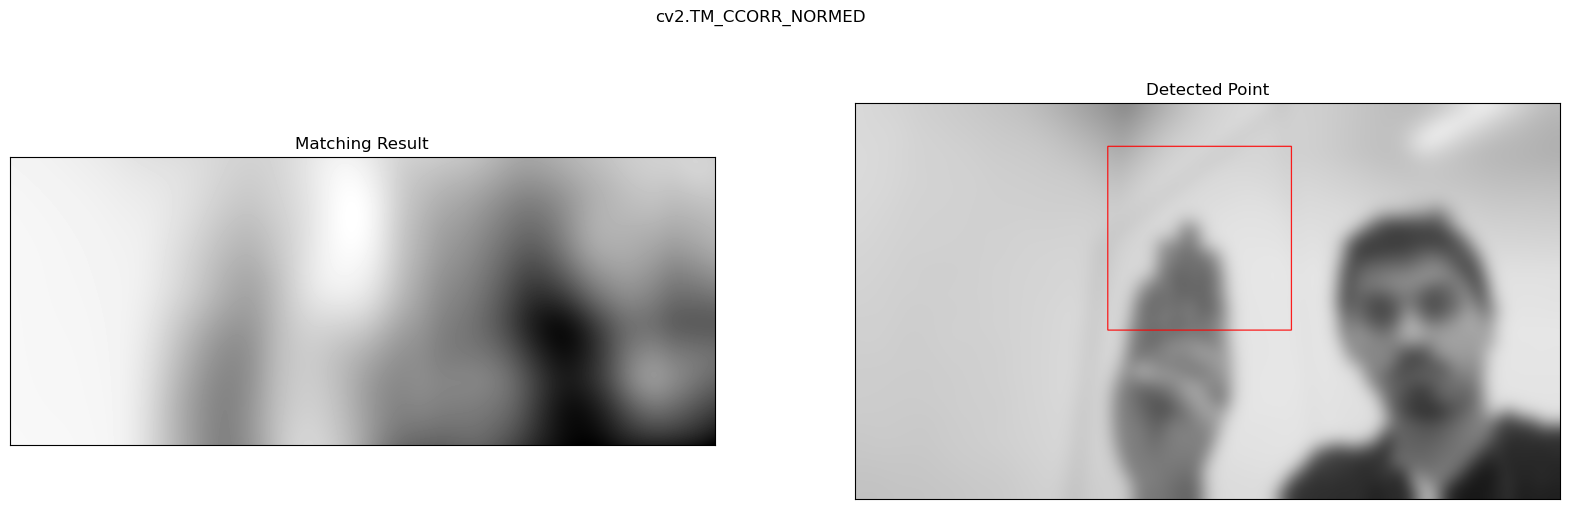

[0.9919792413711548, 0.9861183166503906, 0.9919156432151794, 0.991117537021637]
0
B


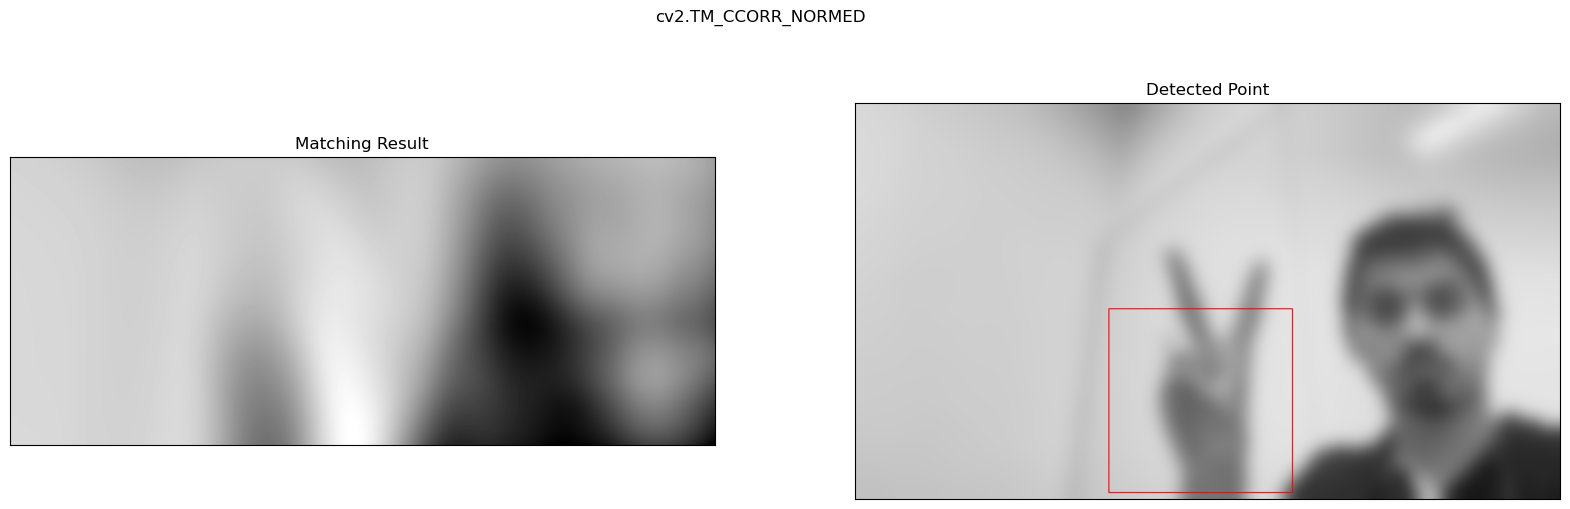

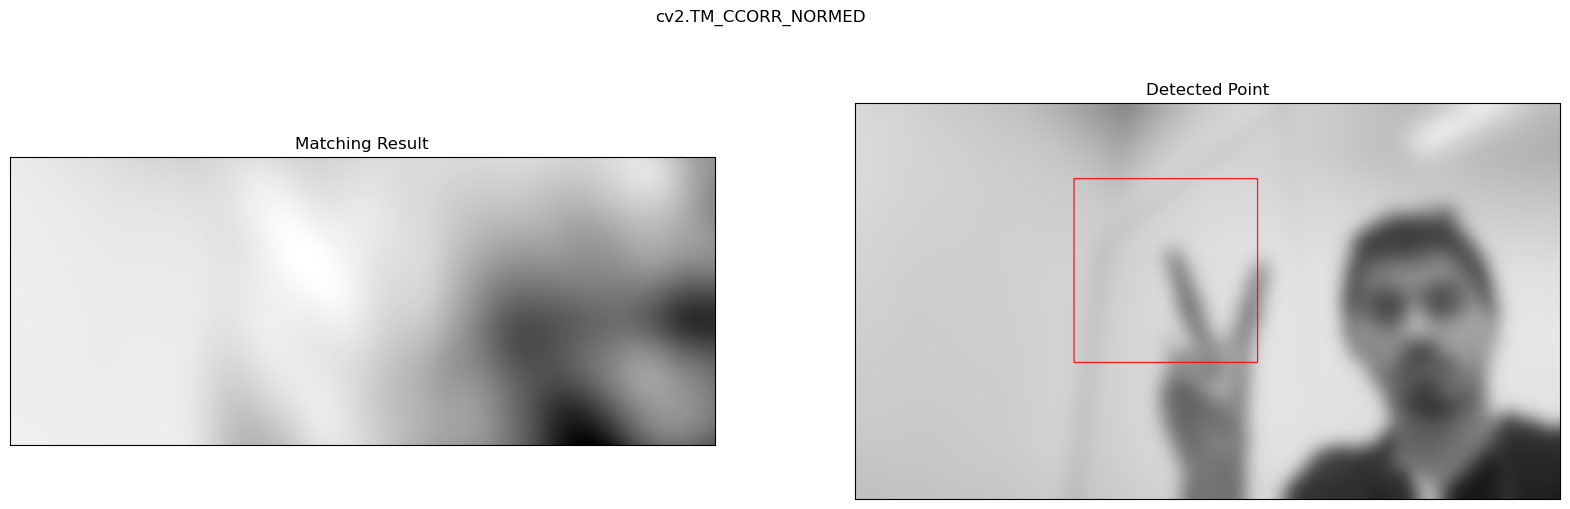

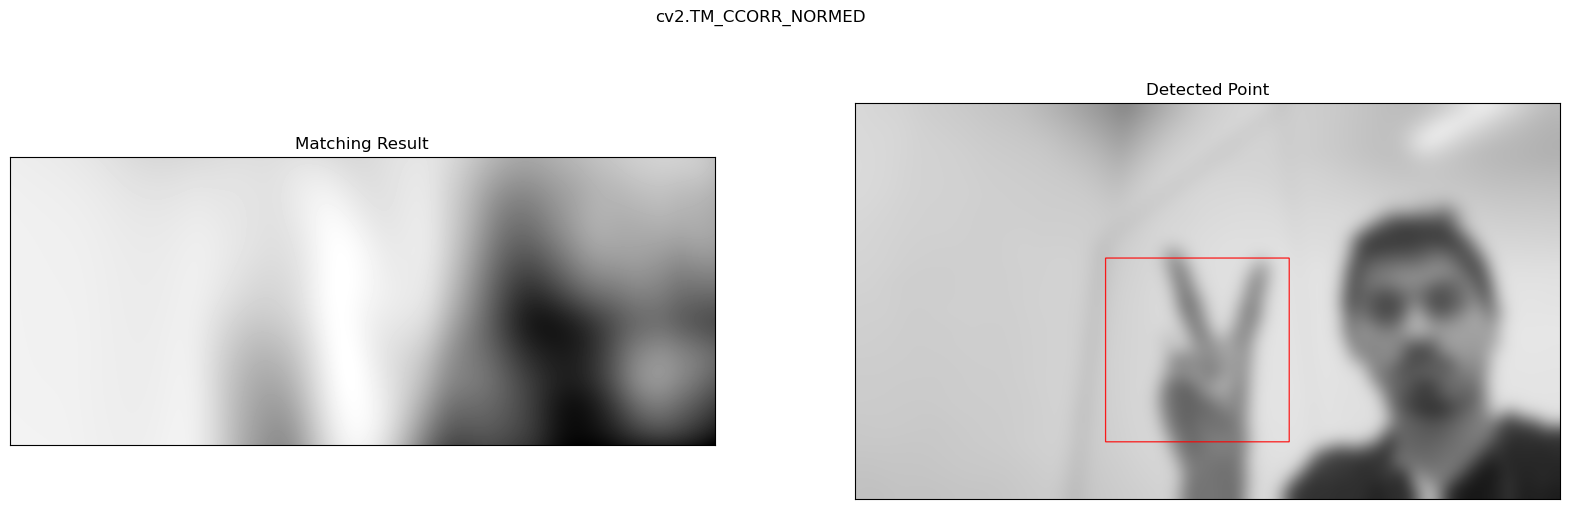

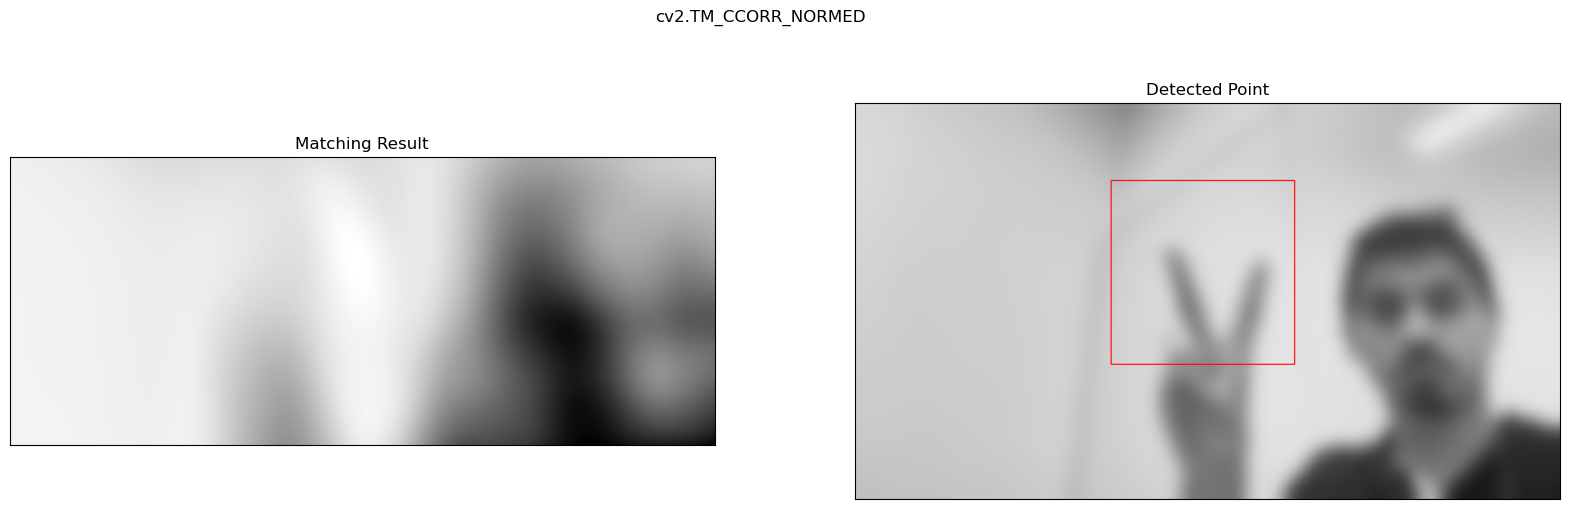

[0.9925573468208313, 0.9889666438102722, 0.9915217161178589, 0.9926565289497375]
3
V


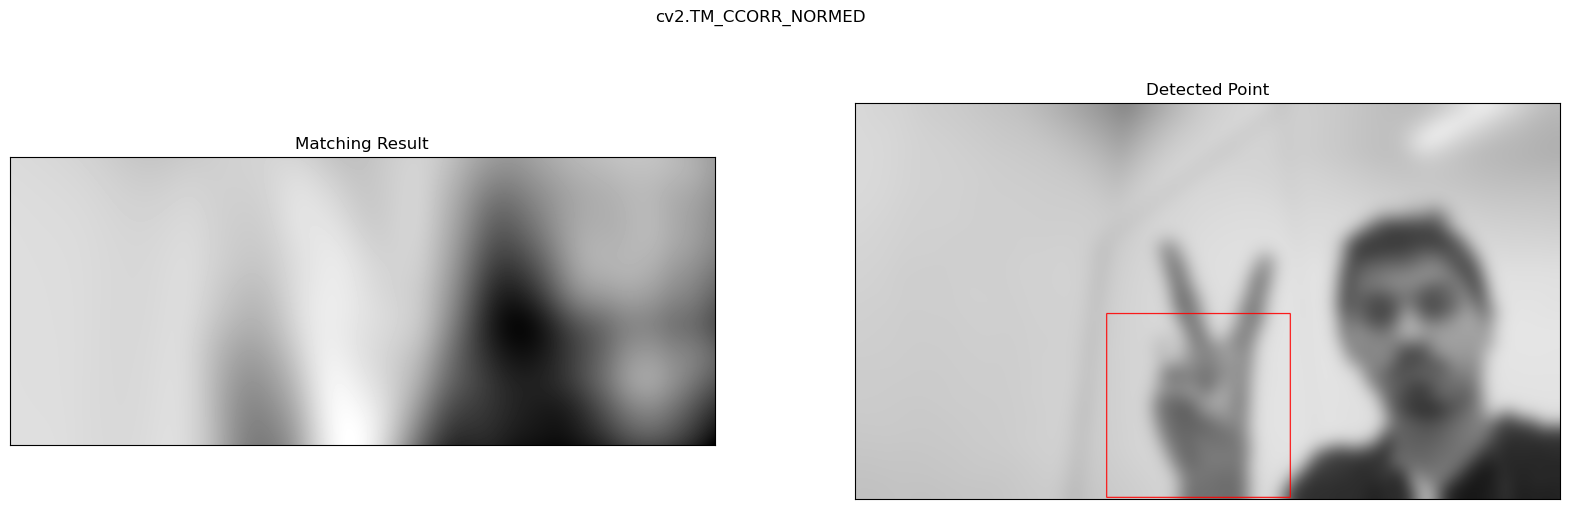

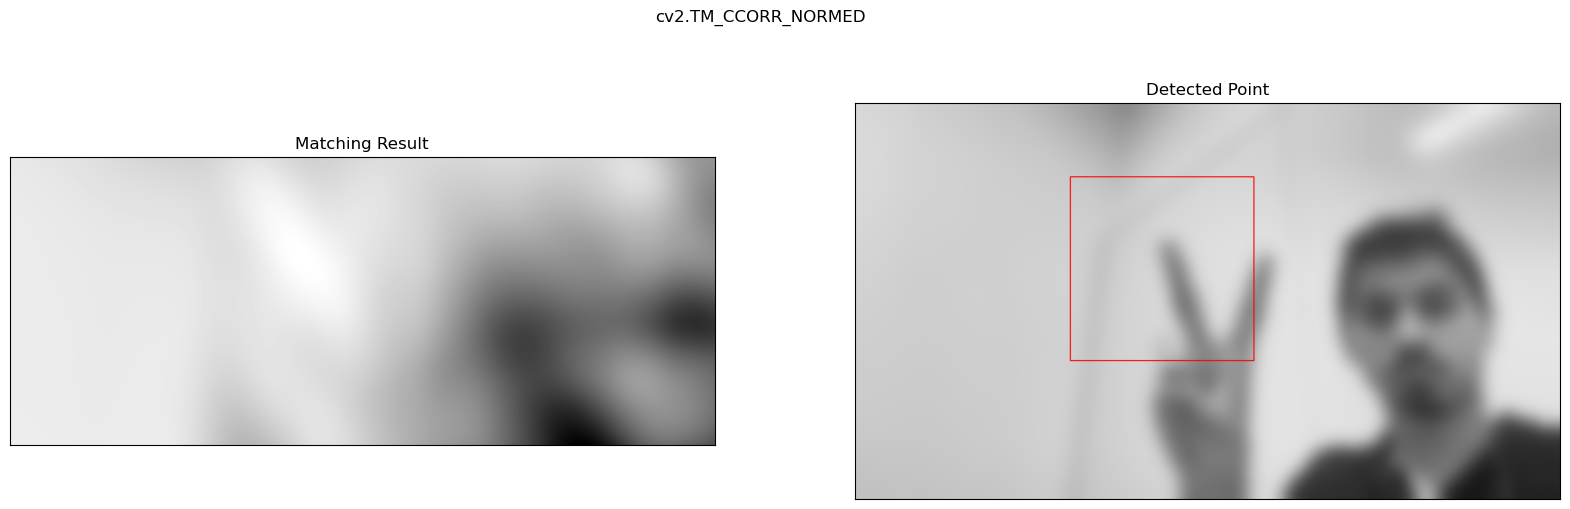

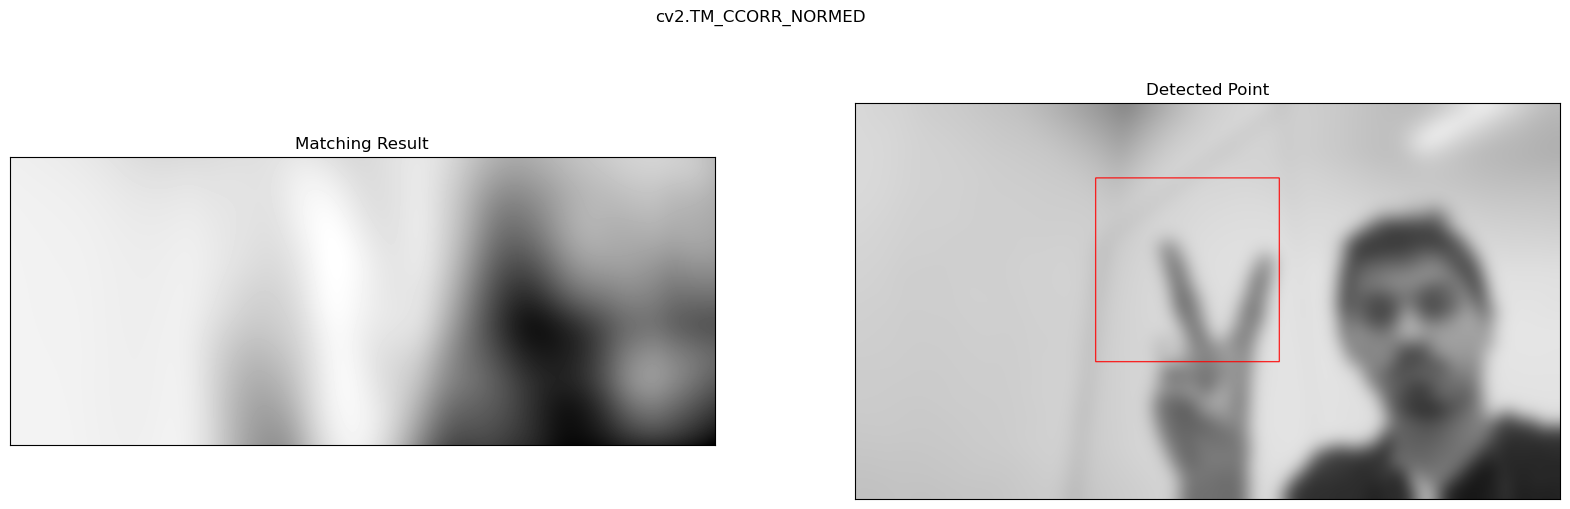

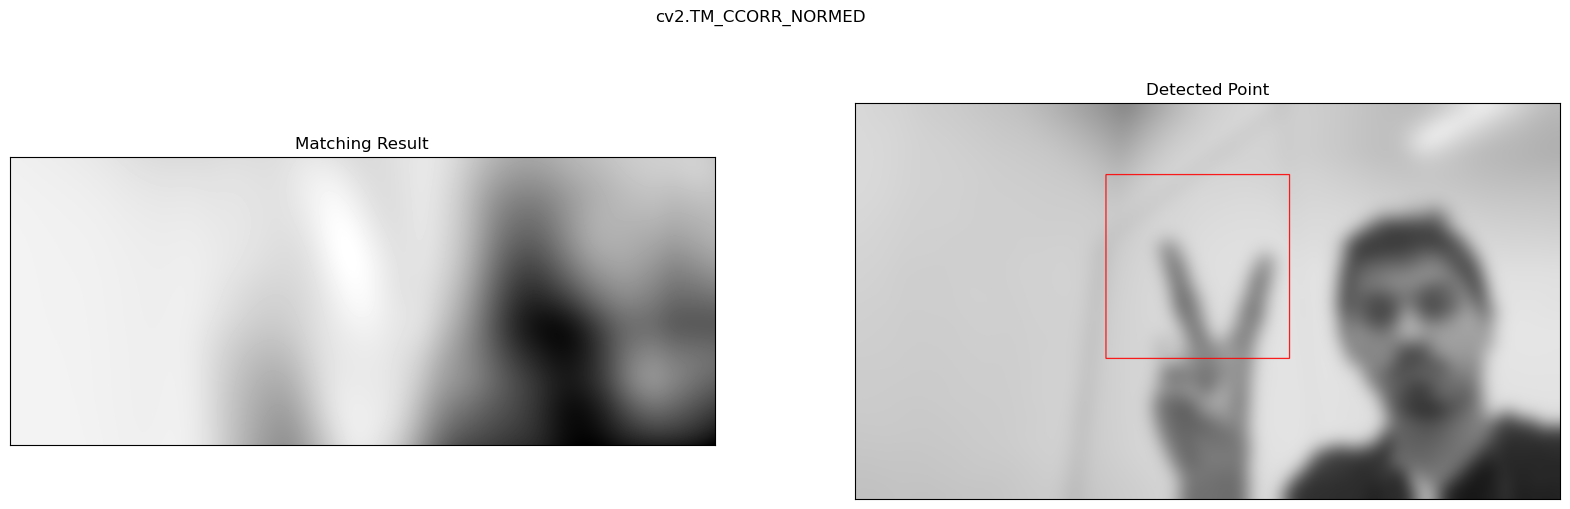

[0.9907298684120178, 0.9897255301475525, 0.9912228584289551, 0.992567241191864]
3
V


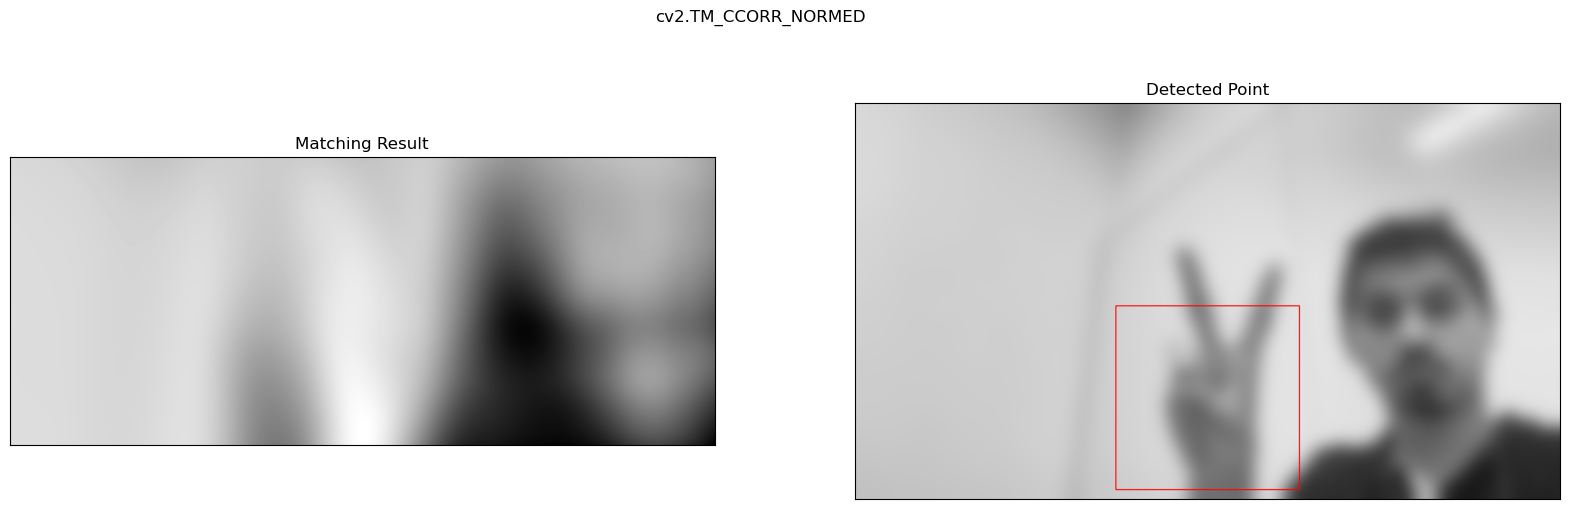

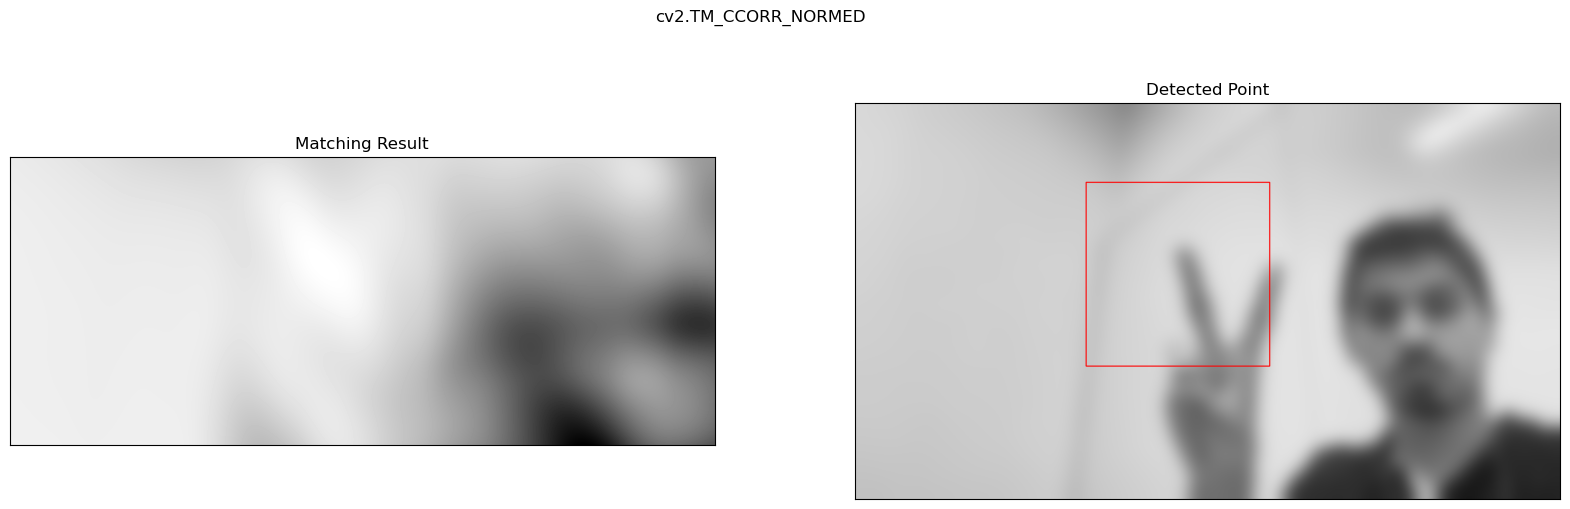

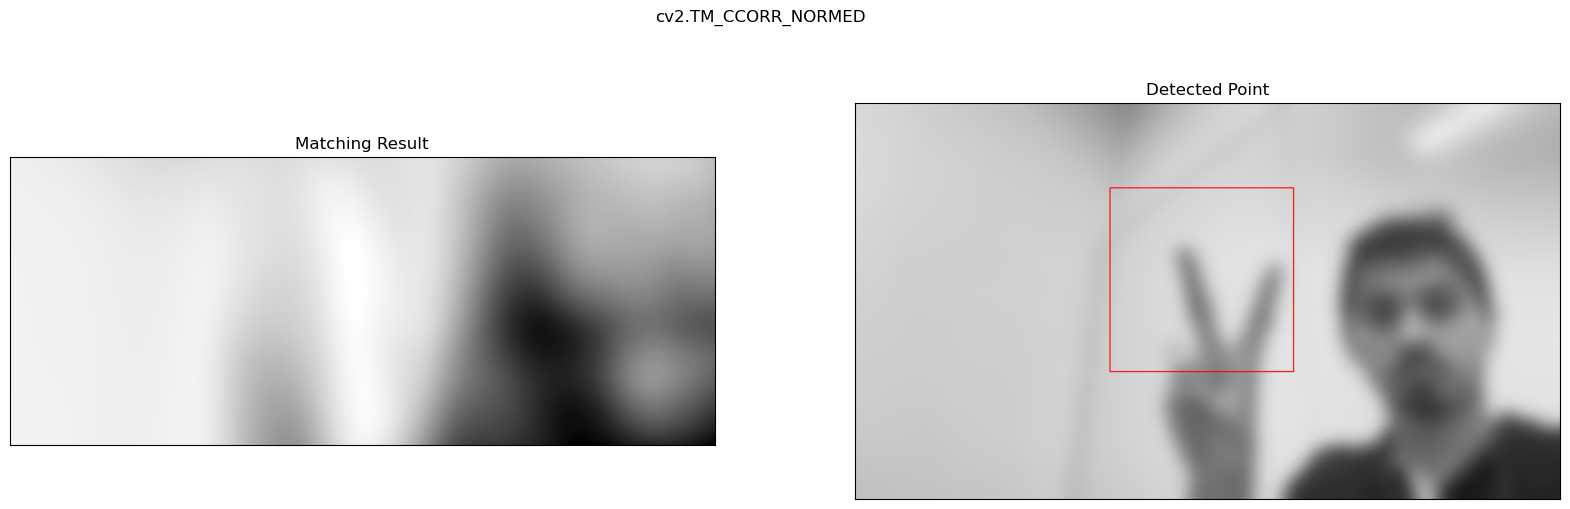

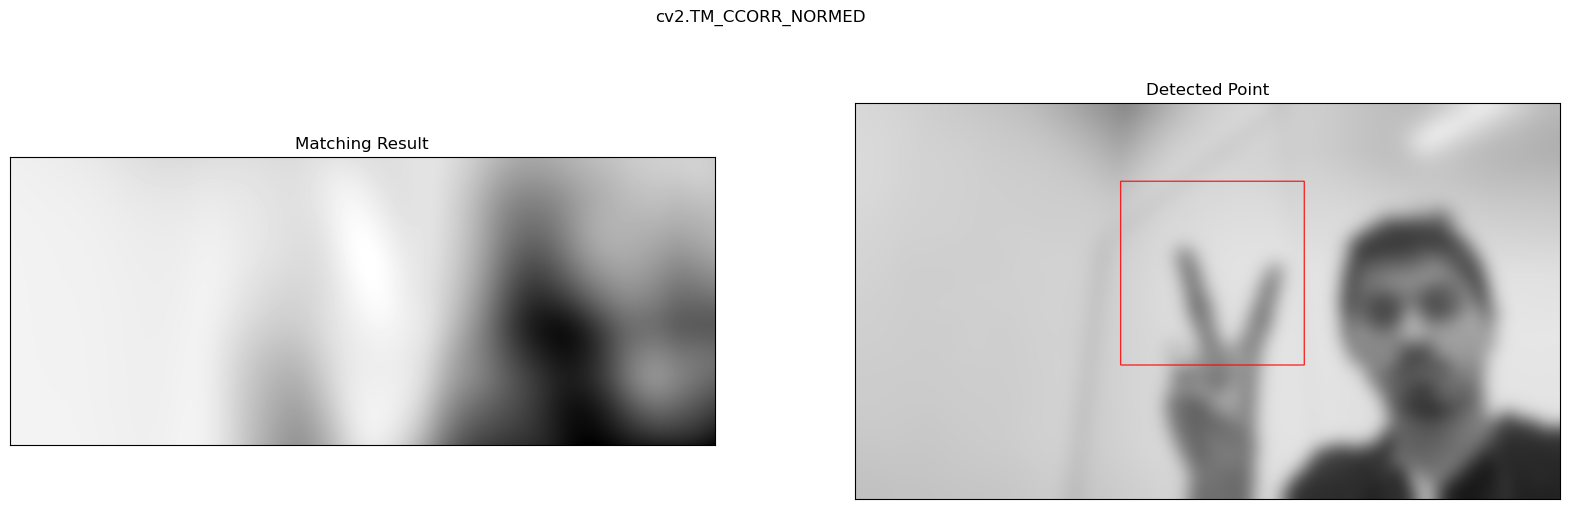

[0.9912524819374084, 0.988610029220581, 0.9915586709976196, 0.9927456974983215]
3
V


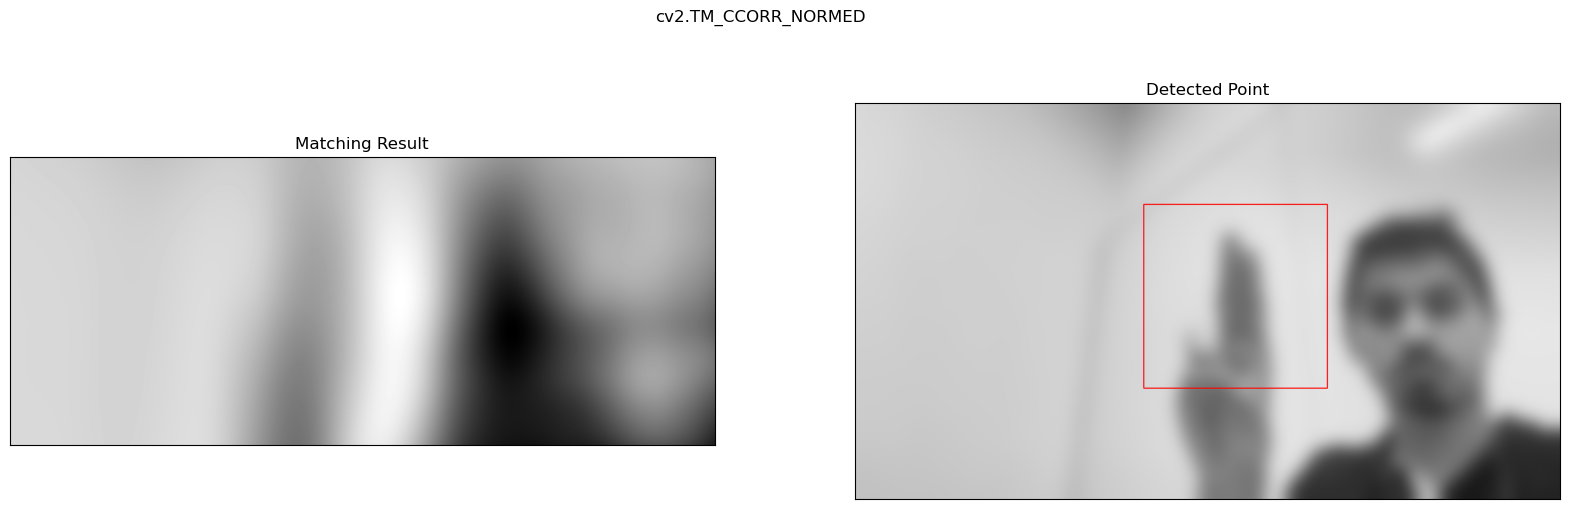

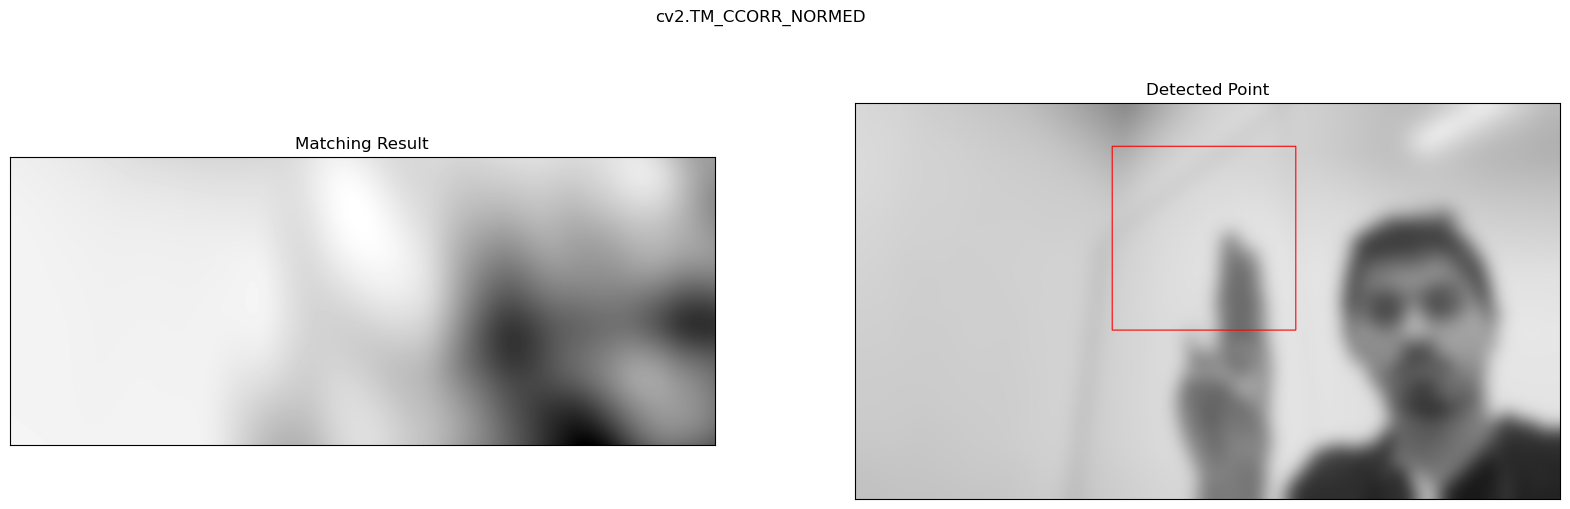

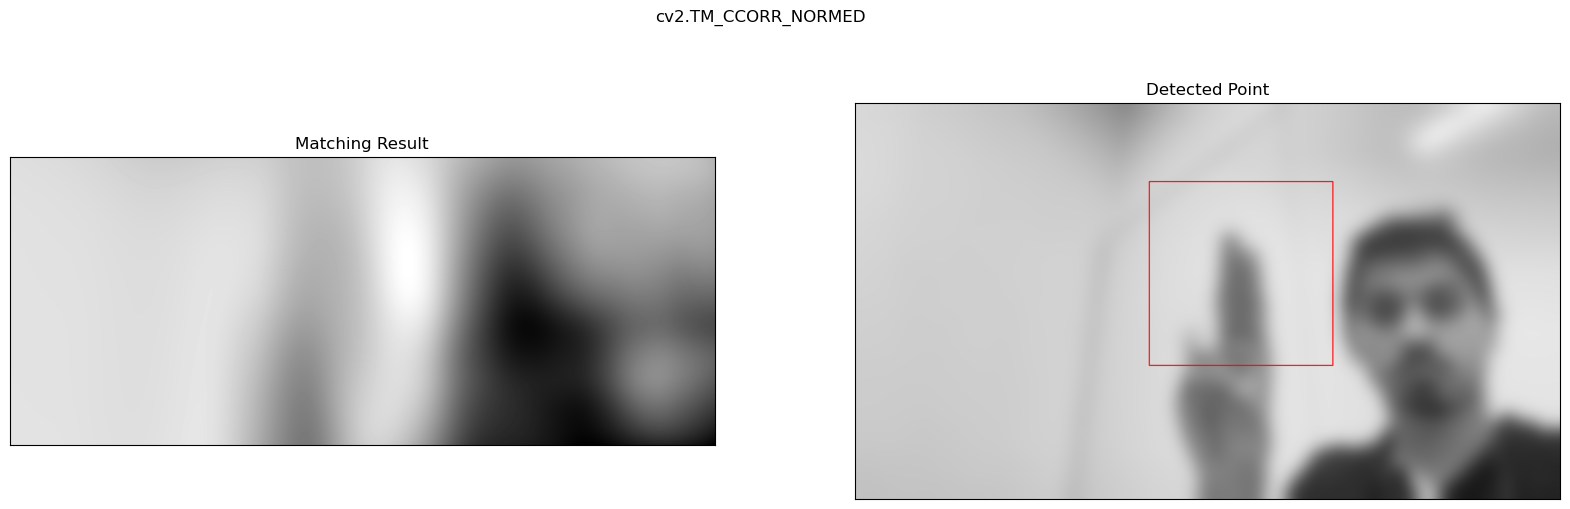

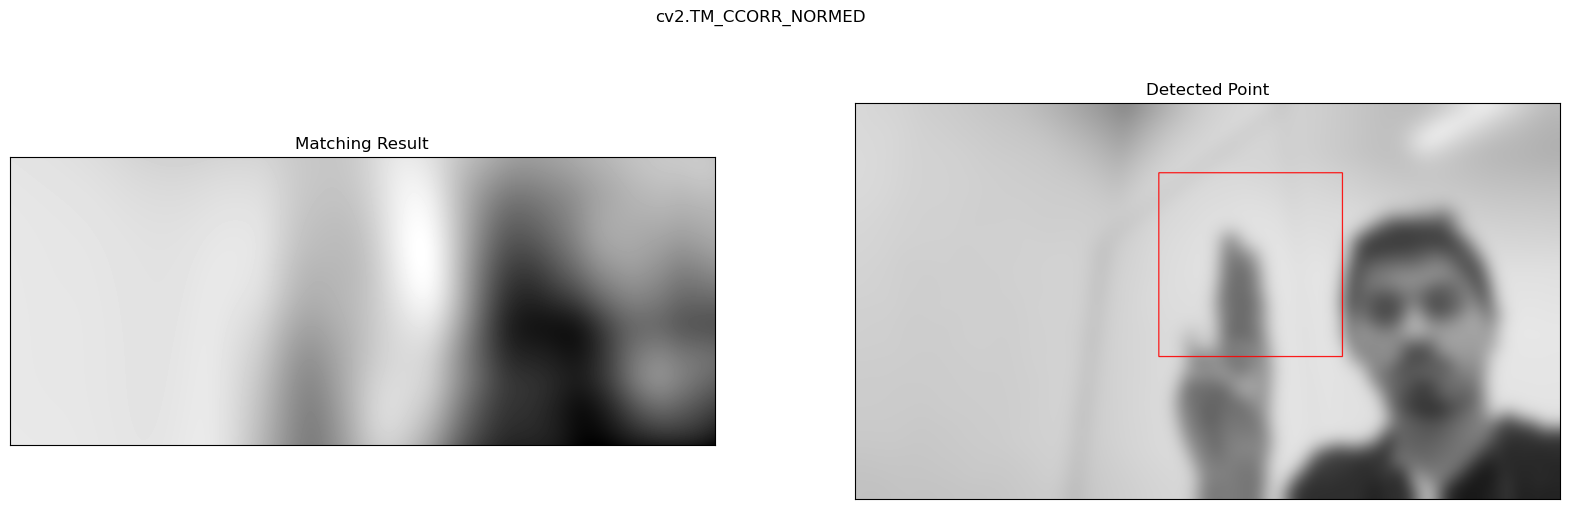

[0.9939945936203003, 0.9868000149726868, 0.9968712329864502, 0.9965871572494507]
2
U


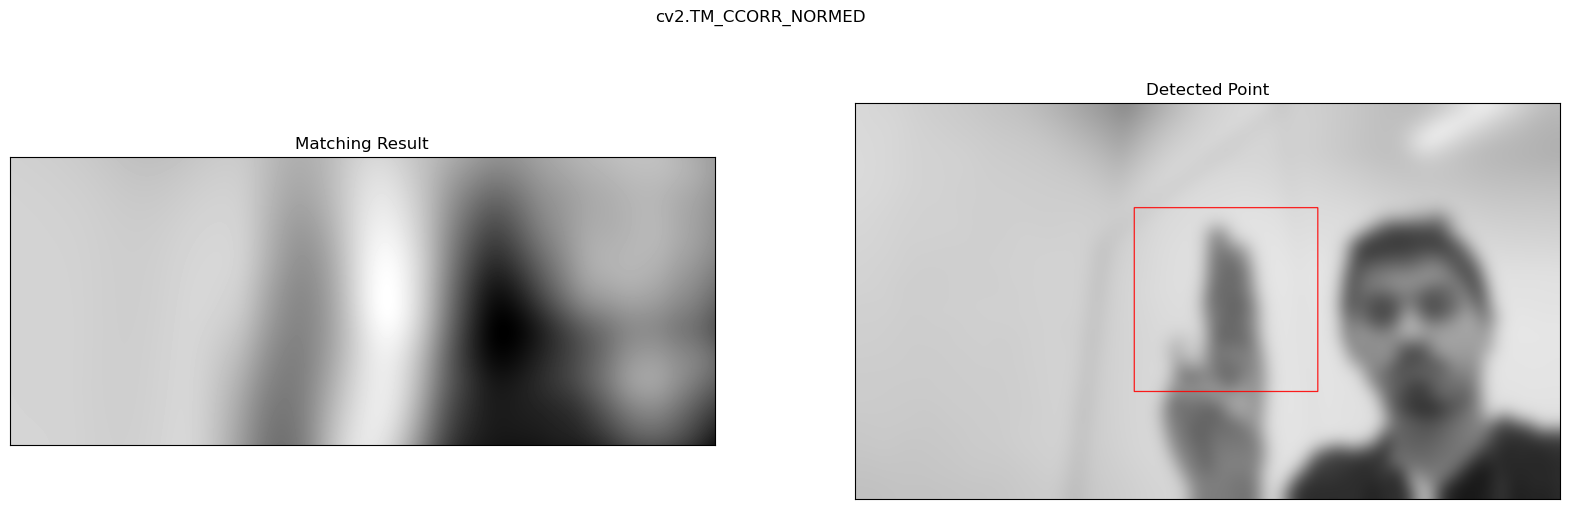

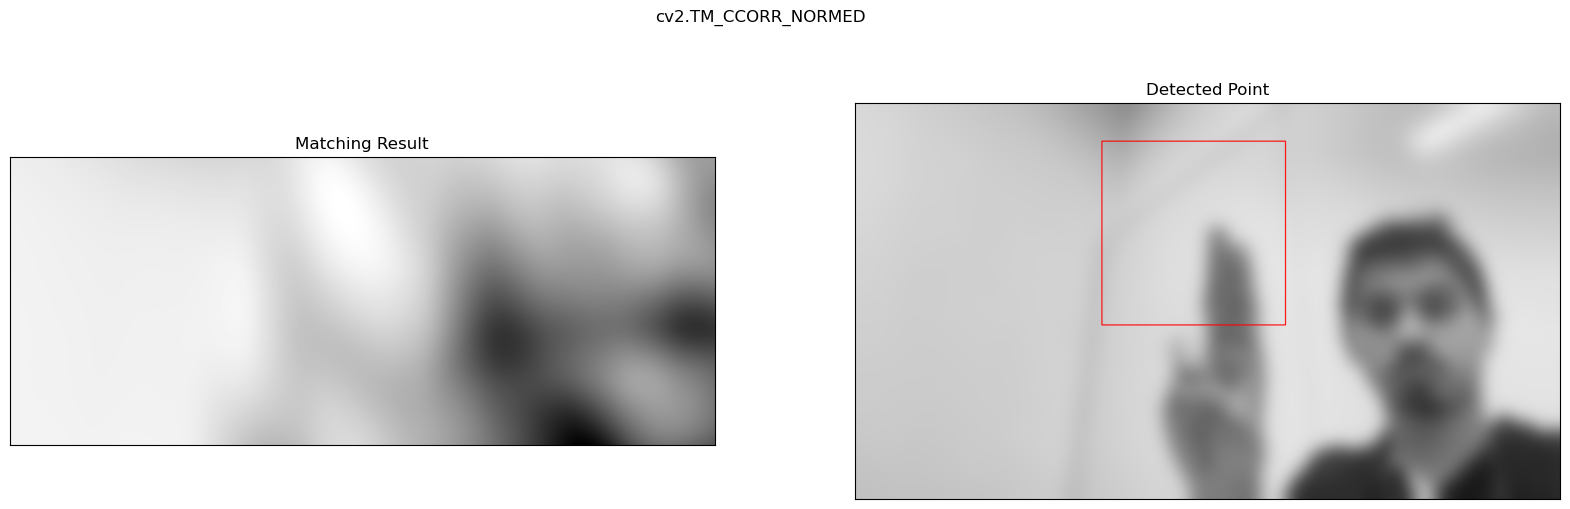

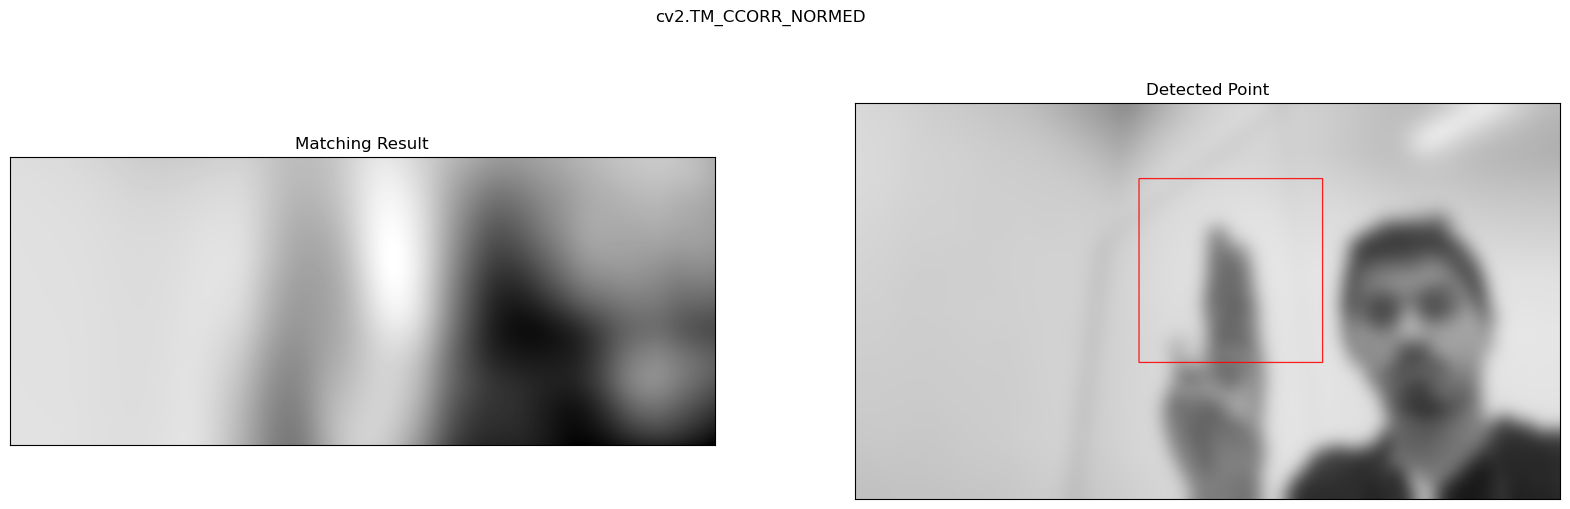

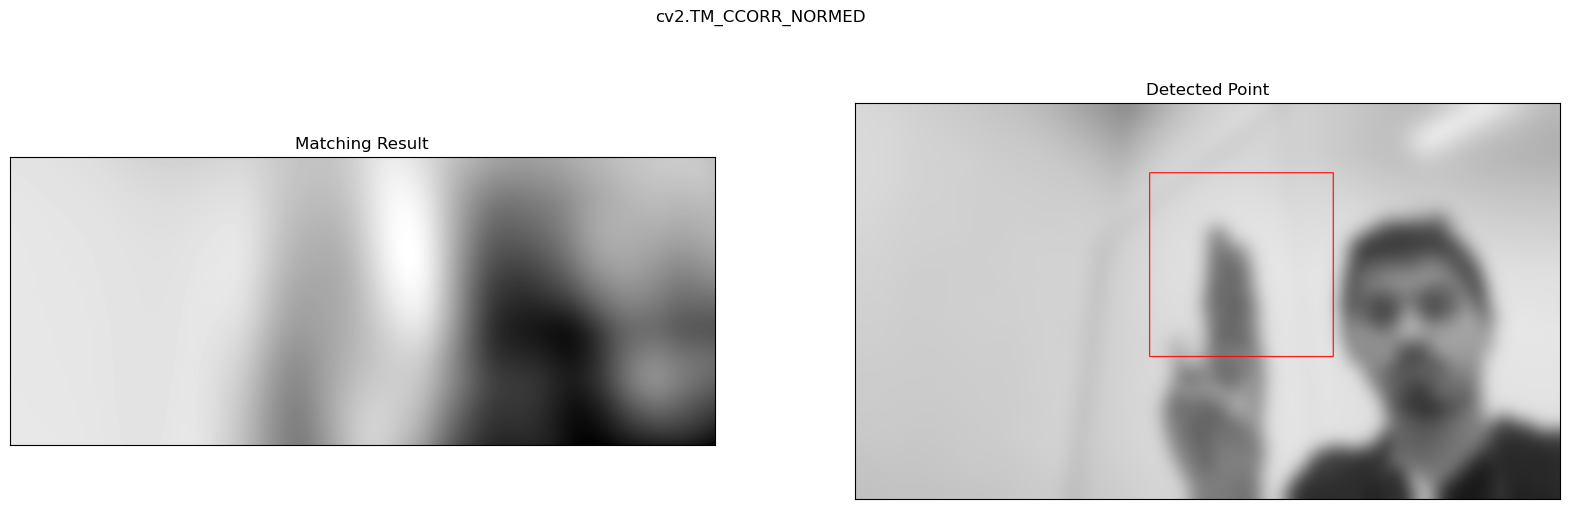

[0.9959014058113098, 0.9871471524238586, 0.9972798824310303, 0.9967604875564575]
2
U


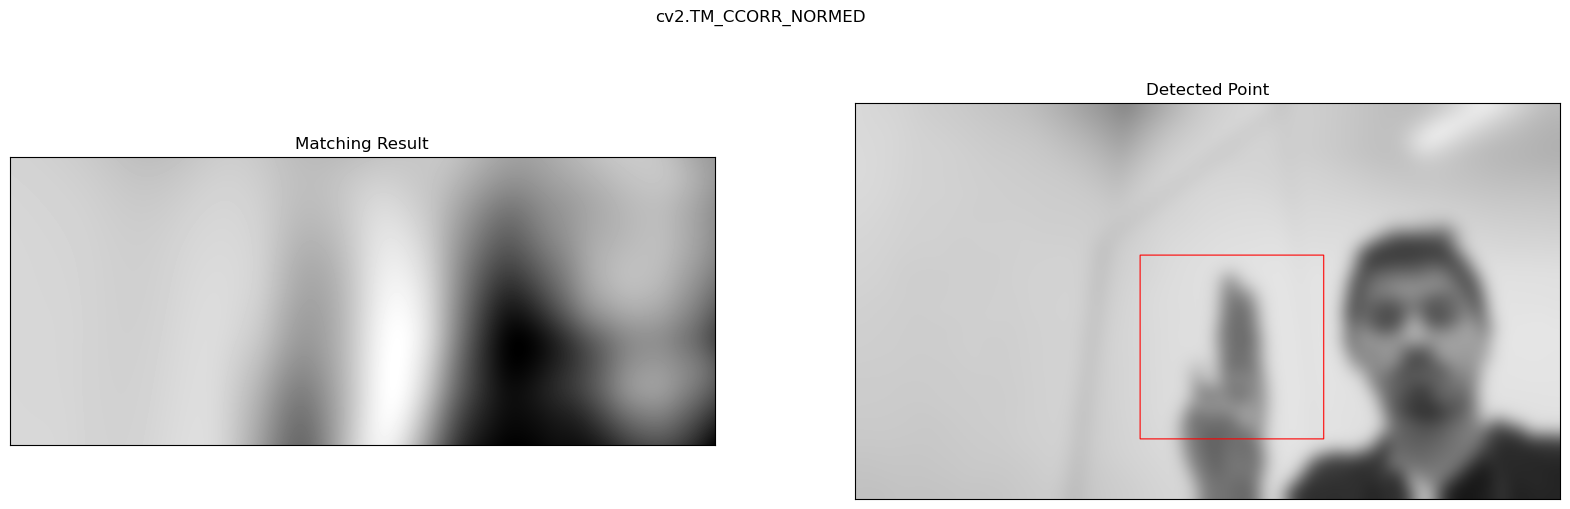

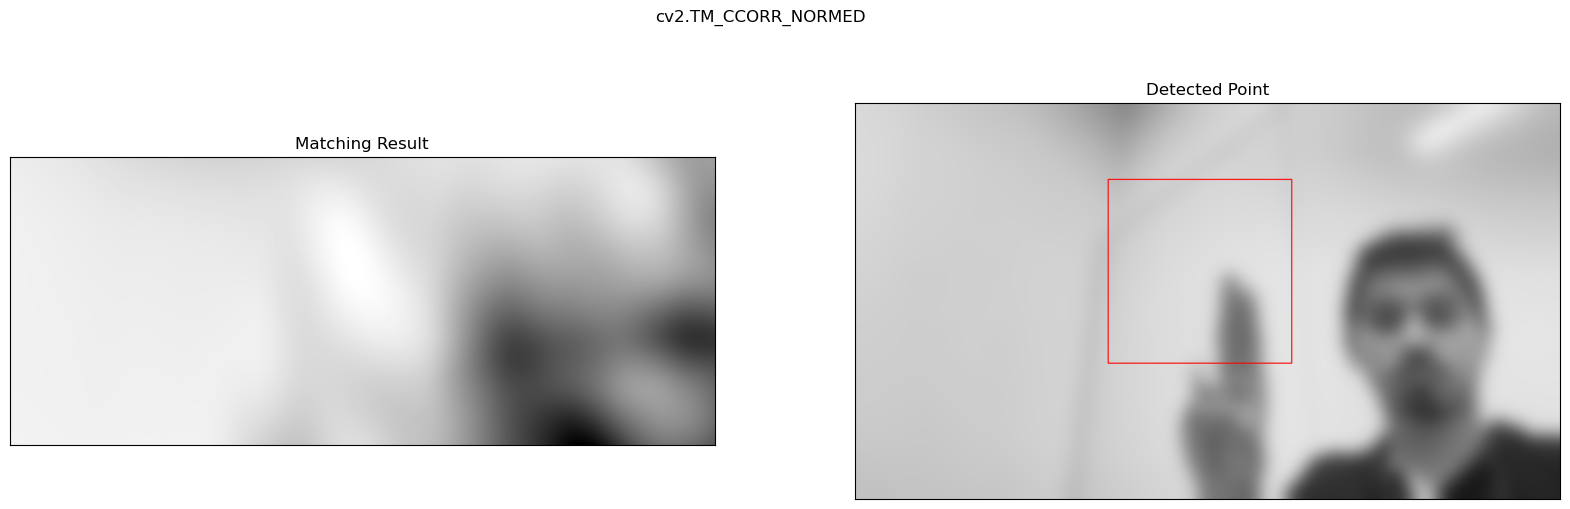

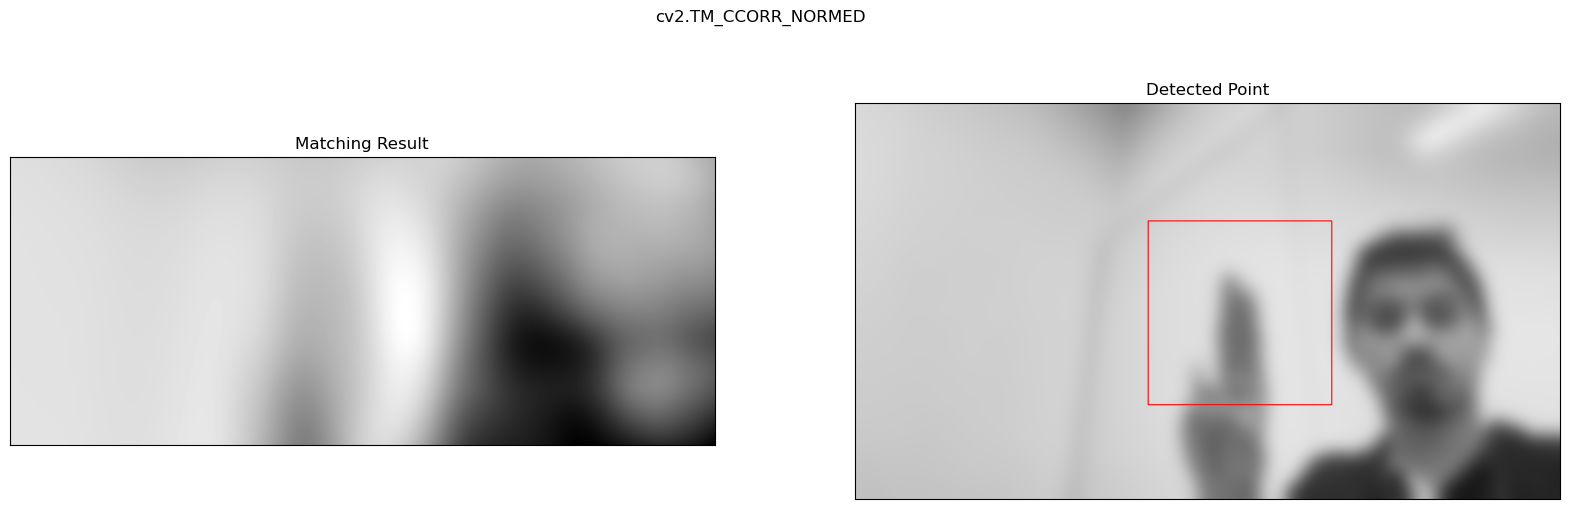

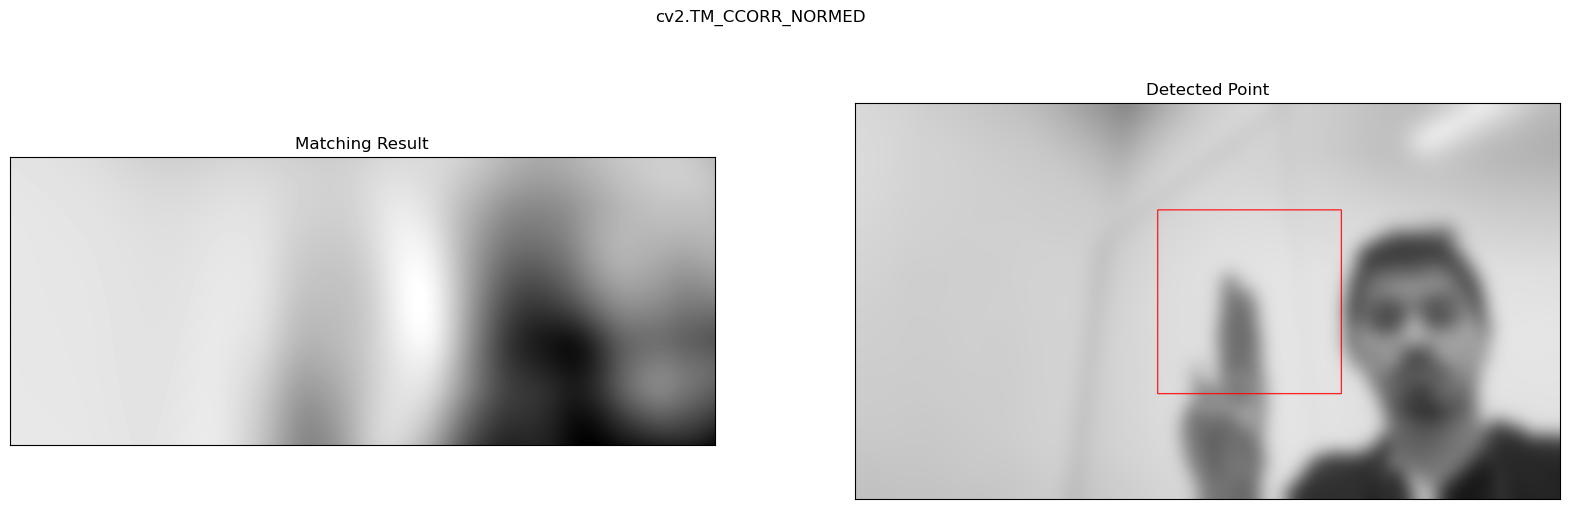

[0.9931752681732178, 0.9875616431236267, 0.996645987033844, 0.9965571165084839]
2
U
esc key is pressed by user


-1

In [35]:
# ----------------
# a) Reading a stream of images from a webcamera, and displaying the video
# ----------------
# For more information on reading and writing video: http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html
# open the video camera no. 0
cap = cv2.VideoCapture(0)

# if not successful, exit program
if not cap.isOpened():
    print("Cannot open the video cam")
    sys.exit()

# create a window called "MyVideo0"
cv2.namedWindow("MyVideo0", cv2.WINDOW_AUTOSIZE)

# read a new frame from video
ret, frame0 = cap.read()
if not ret:
    print("Cannot read a frame from video stream")
1
# show the frame in "MyVideo" window
cv2.imshow("MyVideo0", frame0)


# create windows
cv2.namedWindow("TemplateMatching", cv2.WINDOW_AUTOSIZE)


while(1):
    # read a new frame from video
    ret, frame = cap.read()
    # if not successful, break loop
    if not ret:
        print("Cannot read a frame from video stream")
        break

    cv2.imshow("MyVideo0", frame)
    
    # ----------------
    #  a) Template Matching
    # ----------------
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    blurred_frame = cv2.GaussianBlur(frame, (151,151), 0)

    # call my_template_matching function
    best_template(blurred_frame, blurred_templates_list)

    
    # wait for 'esc' key press for 30ms. If 'esc' key is pressed, break loop
    if cv2.waitKey(30) == 27:
        print("esc key is pressed by user")
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

In [25]:
# ----------------
# a) Reading a stream of images from a webcamera, and displaying the video
# ----------------
# For more information on reading and writing video: http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html
# open the video camera no. 0
cap = cv2.VideoCapture(0)

# if not successful, exit program
if not cap.isOpened():
    print("Cannot open the video cam")
    sys.exit()

# create a window called "MyVideo0"
cv2.namedWindow("MyVideo0", cv2.WINDOW_AUTOSIZE)

# read a new frame from video
ret, frame0 = cap.read()
if not ret:
    print("Cannot read a frame from video stream")

# show the frame in "MyVideo" window
cv2.imshow("MyVideo0", frame0)

# create windows
cv2.namedWindow("FrameDiff", cv2.WINDOW_AUTOSIZE)
cv2.namedWindow("MotionEnergy", cv2.WINDOW_AUTOSIZE)
cv2.namedWindow("Skin", cv2.WINDOW_AUTOSIZE)
cv2.namedWindow("TemplateMatching", cv2.WINDOW_AUTOSIZE)

len_history = 7
my_motion_history = []
fMH1 = np.zeros(np.shape(frame0)[:-1], dtype=np.uint8)
for i in range(len_history):
    my_motion_history.append(fMH1)


while(1):
    # read a new frame from video
    ret, frame = cap.read()
    # if not successful, break loop
    if not ret:
        print("Cannot read a frame from video stream")
        break

    cv2.imshow("MyVideo0", frame)

    # ----------------
    # b) Skin color detection
    # ----------------
    frame_dst = my_skin_detect(frame)
    cv2.imshow("Skin", frame_dst)

    # ----------------
    # c) Background differencing and motion energy
    # ----------------

    # call my_frame_differencing function
    frame_dst = my_frame_differencing(frame0, frame)
    cv2.imshow("FrameDiff", frame_dst)

    my_motion_history.pop(0)
    my_motion_history.append(frame_dst)

    # ----------------
    #  d) Visualizing motion history
    # ----------------

    # call my_motion_energy function
    myMH = my_motion_energy(my_motion_history)
    cv2.imshow("MotionEnergy", myMH) # show the frame in "MyVideo" window
    frame0 = frame
    
    # ----------------
    #  e) Template Matching
    # ----------------

    # call my_motion_energy function
    myMH = my_motion_energy(my_motion_history)
    cv2.imshow("MotionEnergy", myMH) # show the frame in "MyVideo" window
    frame0 = frame

    # wait for 'esc' key press for 30ms. If 'esc' key is pressed, break loop
    if cv2.waitKey(30) == 27:
        print("esc key is pressed by user")
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

esc key is pressed by user


-1

In [ ]:
# Load the image and template
